In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
df = pd.read_csv('reported_hospital_capacity_admissions_facility_level_weekly_average_timeseries_20201215_geocoded.csv', index_col=0)
df

,hospital_pk,collection_week,state,ccn,hospital_name,address,city,zip,hospital_subtype,fips_code,...,previous_day_admission_adult_covid_suspected_50-59_7_day_sum,previous_day_admission_adult_covid_suspected_60-69_7_day_sum,previous_day_admission_adult_covid_suspected_70-79_7_day_sum,previous_day_admission_adult_covid_suspected_80+_7_day_sum,previous_day_admission_adult_covid_suspected_unknown_7_day_sum,previous_day_admission_pediatric_covid_suspected_7_day_sum,previous_day_total_ED_visits_7_day_sum,previous_day_admission_influenza_confirmed_7_day_sum,lat,lng
0,ff9032c172057190bf52f523d253c79af2d5f74d007084...,2020-12-04,PR,NaN,HealthproMed,Avenida Borinquen,San Juan,775.0,Short Term,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,18.437672,-66.056066
1,ee04edd185865c38c839812cb2eb5ae5d3f8922e3b629e...,2020-12-04,LA,NaN,Alexandria Emergency Hospital,5900 Coliseum Boulevard,Alexandria,71303.0,Short Term,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.295050,-92.494976
2,aab2bb3ab769da90baf57242c96ec481afb5ec6a233784...,2020-12-04,LA,NaN,Crescent City Surgical Centre,3017 Galleria,Metairie,70118.0,Short Term,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.993260,-90.153020
3,df2363988746840134806aa7b2accf9c89259601776986...,2020-12-04,PR,NaN,Hospital San Antonio,#18 Norte Calle Ramón Emeterio Betances,Mayagüez,680.0,Short Term,NaN,...,0.0,0.0,0.0,0.0,0.0,-999999.0,163.0,0.0,18.203115,-67.141196
4,3b081d5ef1c552538e4af4aa593a857bb922a4f364a412...,2020-12-04,LA,NaN,Surgery Center of Zachary,4845 Main St,Zachary,70791.0,Short Term,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.648624,-91.152534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92264,400130,2020-07-31,PR,400130,HOSPITAL METROPOLITANO DE LA MONTANA,NaN,Utuado,641.0,Short Term,72141.0,...,0.0,0.0,0.0,0.0,0.0,0.0,35.0,NaN,18.267567,-66.701342
92265,400115,2020-07-31,PR,400115,CENTRO MEDICO WILMA N VAZQUEZ,Carretera #2 Km,Vega Baja,693.0,Short Term,72145.0,...,9.0,12.0,9.0,10.0,0.0,4.0,170.0,NaN,18.445622,-66.398985
92266,400110,2020-07-31,PR,400110,HOSPITAL METROPOLITANO DR TITO MATTEI,1901 1st Avenue,New York,698.0,Short Term,72153.0,...,0.0,4.0,0.0,0.0,0.0,0.0,274.0,NaN,40.784833,-73.944413
92267,480002,2020-07-31,VI,480002,GOV JUAN F LUIS HOSPITAL & MEDICAL CTR,4007 Estate Diamond Ruby,Christiansted,820.0,Short Term,78010.0,...,0.0,0.0,0.0,-999999.0,0.0,0.0,193.0,NaN,17.733683,-64.751426


In [3]:
print(df.columns)

Index(['hospital_pk', 'collection_week', 'state', 'ccn', 'hospital_name',
       'address', 'city', 'zip', 'hospital_subtype', 'fips_code',
       'is_metro_micro', 'total_beds_7_day_avg',
       'all_adult_hospital_beds_7_day_avg',
       'all_adult_hospital_inpatient_beds_7_day_avg',
       'inpatient_beds_used_7_day_avg',
       'all_adult_hospital_inpatient_bed_occupied_7_day_avg',
       'total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg',
       'total_adult_patients_hospitalized_confirmed_covid_7_day_avg',
       'total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg',
       'total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg',
       'inpatient_beds_7_day_avg', 'total_icu_beds_7_day_avg',
       'total_staffed_adult_icu_beds_7_day_avg', 'icu_beds_used_7_day_avg',
       'staffed_adult_icu_bed_occupancy_7_day_avg',
       'staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg',
       'staffed_icu_adult_p

In [4]:
df['zip'] = df['zip'].apply(lambda x: int(x) if x == x else "")

In [5]:
df = df.sort_values(['collection_week']).reset_index(drop=True)

# Data Exploration

### Assumptions

Total beds vs. inpatient beds - Inpatient beds are defined as beds that are regularly maintained and staffed [[source]](https://deputyprimeminister.gov.mt/en/dhir/documents/definitions_and_classifications.pdf)

The value `-999999` indicates redacted data due to privacy concerns. From HealthcareGov:
> When there are fewer than 4 patients in a data field the cell is redacted and replaced with -999999. This value was chosen to ensure that users would not make the mistake of quickly “averaging” a column to come to a conclusion that does not account for the fact that many of the cells contain too few patients to release (for privacy concerns). To conduct analysis on this data, one must decide how to handle the -999999 fields.

tl;dr: If calculated metric falls out of bounds, recalculate using related values. Redacted values will be interpreted as 1 only in a last-case scenario, as we know there is at least 1 patient given the conditions of redaction.

### Goal

Visualize capacity week by week. Due to low occurance of pediatric cases, only adult patient metrics are calculated.
 
What data do we need?
- ID: `hospital_name`
- Location: `hospital_name`, `address`, `city`, `zip`, `lat`, `lng`

Metric calculations, ideal:

- Percentage of Bed Occupancy (COVID and non-COVID) (Of all beds, how many are occupied?):
`all_adult_hospital_inpatient_bed_occupied_7_day_avg / all_adult_hospital_inpatient_beds_7_day_avg `
- Percentage of Patients with COVID (Of all beds, how many are occupied by patients with COVID?):
`total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg / all_adult_hospital_inpatient_bed_occupied_7_day_avg`

- Percentage of ICU Occupancy (COVID and non-COVID) (Of all ICU beds, how many are occupied?): 
`staffed_adult_icu_bed_occupancy_7_day_avg / total_staffed_adult_icu_beds_7_day_avg`
- Percentage of ICU Occupancy (COVID and non-COVID) (Of all ICU beds, how many are occupied by patients with COVID?):
`staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg / total_staffed_adult_icu_beds_7_day_avg`

List of all values available for calculating/estimating metrics:

`'all_adult_hospital_inpatient_beds_7_day_avg'`
`'all_adult_hospital_inpatient_bed_occupied_7_day_avg'`
`'inpatient_beds_used_7_day_avg'`
`'total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg'`
`'total_adult_patients_hospitalized_confirmed_covid_7_day_avg'`
`'total_beds_7_day_avg'`

`'total_staffed_adult_icu_beds_7_day_avg'`
`'staffed_adult_icu_bed_occupancy_7_day_avg'`
`'icu_beds_used_7_day_avg'`
`'staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg'`
`'staffed_icu_adult_patients_confirmed_covid_7_day_avg'`
`'total_icu_beds_7_day_avg'`

In [6]:
weeks_list = df['collection_week'].unique()
print(weeks_list)
print(f'{len(weeks_list)} weeks of data')

['2020-07-31' '2020-08-07' '2020-08-14' '2020-08-21' '2020-08-28'
 '2020-09-04' '2020-09-11' '2020-09-18' '2020-09-25' '2020-10-02'
 '2020-10-09' '2020-10-16' '2020-10-23' '2020-10-30' '2020-11-06'
 '2020-11-13' '2020-11-20' '2020-11-27' '2020-12-04']
19 weeks of data


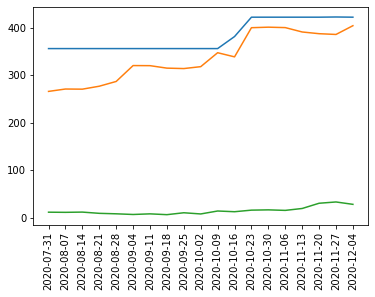

In [7]:
df_sample = df[df['hospital_name'] == 'OHSU HOSPITAL AND CLINICS']
plt.plot(df_sample['collection_week'], df_sample['all_adult_hospital_inpatient_beds_7_day_avg'])
plt.plot(df_sample['collection_week'], df_sample['all_adult_hospital_inpatient_bed_occupied_7_day_avg'])
plt.plot(df_sample['collection_week'], df_sample['total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg'])
plt.xticks(rotation=90)
plt.show()

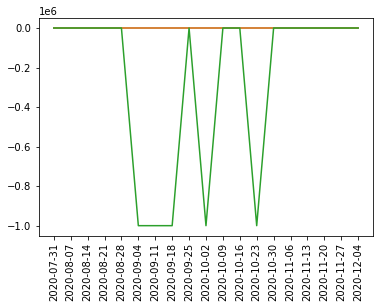

In [8]:
plt.plot(df_sample['collection_week'], df_sample['total_staffed_adult_icu_beds_7_day_avg'])
plt.plot(df_sample['collection_week'], df_sample['staffed_adult_icu_bed_occupancy_7_day_avg'])
plt.plot(df_sample['collection_week'], df_sample['staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg'])
plt.xticks(rotation=90)
plt.show()

Data looks interesting, but redacted values need to go. Errors exist in the entry of data, they must be corrected as well.

In [9]:
df_explore = df.copy(deep=True)

No redacted values here

 **NOTE TO SELF: REPLACING WITH `None` DOES NOT WORK. PANDAS WILL INFER DATA FROM ROW ABOVE**

In [10]:
avg_cols = ['all_adult_hospital_inpatient_beds_7_day_avg', 
            'all_adult_hospital_inpatient_bed_occupied_7_day_avg', 
            'inpatient_beds_used_7_day_avg',
            'total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg',
            'total_adult_patients_hospitalized_confirmed_covid_7_day_avg',
            'total_beds_7_day_avg',
           
            'total_staffed_adult_icu_beds_7_day_avg', 
            'staffed_adult_icu_bed_occupancy_7_day_avg', 
            'icu_beds_used_7_day_avg',
            'staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg',
            'staffed_icu_adult_patients_confirmed_covid_7_day_avg',
            'total_icu_beds_7_day_avg']

sum_cols = ['all_adult_hospital_inpatient_beds_7_day_sum', 
            'all_adult_hospital_inpatient_bed_occupied_7_day_sum', 
            'inpatient_beds_used_7_day_sum',
            'total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum',
            'total_adult_patients_hospitalized_confirmed_covid_7_day_sum',
            'total_beds_7_day_sum', 
            
            'total_staffed_adult_icu_beds_7_day_sum', 
            'staffed_adult_icu_bed_occupancy_7_day_sum', 
            'icu_beds_used_7_day_sum',
            'staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum',
            'staffed_icu_adult_patients_confirmed_covid_7_day_sum',
            'total_icu_beds_7_day_sum']

cov_cols = ['all_adult_hospital_inpatient_beds_7_day_coverage', 
            'all_adult_hospital_inpatient_bed_occupied_7_day_coverage', 
            'inpatient_beds_used_7_day_coverage',
            'total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_coverage',
            'total_adult_patients_hospitalized_confirmed_covid_7_day_coverage',
            'total_beds_7_day_coverage',
            
            'total_staffed_adult_icu_beds_7_day_coverage', 
            'staffed_adult_icu_bed_occupancy_7_day_coverage', 
            'icu_beds_used_7_day_coverage',
            'staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_coverage',
            'staffed_icu_adult_patients_confirmed_covid_7_day_coverage',
            'total_icu_beds_7_day_coverage']

In [11]:
for col in avg_cols:
    df_explore[col].replace(-999999, np.nan, inplace=True)
    #df_explore[col].mask(lambda x: x==-999999, None, inplace=True)
    print(f'Min: {df_explore[col].min()} | Max: {df_explore[col].max()}')

Min: 0.0 | Max: 2875.4
Min: -6.3 | Max: 2192.7
Min: -17.8 | Max: 2442.4
Min: 0.0 | Max: 929.0
Min: 0.0 | Max: 672.9
Min: 0.0 | Max: 5015.4
Min: 0.0 | Max: 557.7
Min: -3.2 | Max: 5864.4
Min: -3.5 | Max: 409.1
Min: 0.0 | Max: 201.1
Min: 0.0 | Max: 140.4
Min: 0.0 | Max: 849.9


In [12]:
for col in sum_cols:
    df_explore[col].replace(-999999, np.nan, inplace=True)
    print(f'Min: {df_explore[col].min()} | Max: {df_explore[col].max()}')

Min: 0.0 | Max: 20128.0
Min: -44.0 | Max: 15349.0
Min: -107.0 | Max: 17097.0
Min: 0.0 | Max: 6503.0
Min: 0.0 | Max: 4710.0
Min: 0.0 | Max: 35108.0
Min: 0.0 | Max: 3904.0
Min: -19.0 | Max: 41051.0
Min: -21.0 | Max: 2864.0
Min: 0.0 | Max: 1408.0
Min: 0.0 | Max: 983.0
Min: 0.0 | Max: 5949.0


In [13]:
for col in cov_cols:
    df_explore[col].replace(-999999, np.nan, inplace=True)
    print(f'Min: {df_explore[col].min()} | Max: {df_explore[col].max()}')

Min: 0 | Max: 7
Min: 0 | Max: 7
Min: 0 | Max: 7
Min: 0 | Max: 7
Min: 0 | Max: 7
Min: 0 | Max: 7
Min: 0 | Max: 7
Min: 0 | Max: 7
Min: 0 | Max: 7
Min: 0 | Max: 7
Min: 0 | Max: 7
Min: 0 | Max: 7


Why are there negative numbers???

In [14]:
for i, col in enumerate(avg_cols):
    df_neg = df_explore.loc[df_explore[col] < 0][[avg_cols[i], sum_cols[i], cov_cols[i]]]
    if not df_neg.empty:
        display(df_neg)

,all_adult_hospital_inpatient_bed_occupied_7_day_avg,all_adult_hospital_inpatient_bed_occupied_7_day_sum,all_adult_hospital_inpatient_bed_occupied_7_day_coverage
8963,-3.0,-12.0,4
13709,-4.6,-23.0,5
18504,-4.4,-22.0,5
23328,-4.6,-32.0,7
44709,-6.3,-44.0,7
52546,-1.6,-11.0,7


,inpatient_beds_used_7_day_avg,inpatient_beds_used_7_day_sum,inpatient_beds_used_7_day_coverage
8963,-2.4,-12.0,5
13709,-4.6,-23.0,5
18504,-4.4,-22.0,5
23328,-4.6,-32.0,7
28706,-17.8,-107.0,6
44709,-6.3,-44.0,7
52546,-1.6,-11.0,7


,staffed_adult_icu_bed_occupancy_7_day_avg,staffed_adult_icu_bed_occupancy_7_day_sum,staffed_adult_icu_bed_occupancy_7_day_coverage
8963,-1.0,-4.0,4
13709,-1.0,-5.0,5
18504,-1.0,-5.0,5
23328,-1.0,-7.0,7
28706,-3.2,-19.0,6
44709,-1.0,-7.0,7
52546,-0.1,-1.0,7


,icu_beds_used_7_day_avg,icu_beds_used_7_day_sum,icu_beds_used_7_day_coverage
8963,-0.8,-4.0,5
13709,-1.0,-5.0,5
18504,-1.0,-5.0,5
23328,-1.0,-7.0,7
28706,-3.5,-21.0,6
44709,-1.0,-7.0,7
52546,-0.1,-1.0,7


Seems like misentered data. For all negative values that are not redacted, we can take the absolute value of all columns

In [15]:
for col in [avg_cols + sum_cols + cov_cols]:
    df_explore[col] = df_explore[col].abs()

In [16]:
#print min
for avg_col, sum_col, cov_col in zip(avg_cols, sum_cols, cov_cols):
    print(f'Avg - Min: {df_explore[avg_col].min()} | Max: {df_explore[avg_col].max()}')
    print(f'Sum - Min: {df_explore[sum_col].min()} | Max: {df_explore[sum_col].max()}')
    print(f'Cov - Min: {df_explore[cov_col].min()} | Max: {df_explore[cov_col].max()}')

Avg - Min: 0.0 | Max: 2875.4
Sum - Min: 0.0 | Max: 20128.0
Cov - Min: 0.0 | Max: 7.0
Avg - Min: 0.0 | Max: 2192.7
Sum - Min: 0.0 | Max: 15349.0
Cov - Min: 0.0 | Max: 7.0
Avg - Min: 0.0 | Max: 2442.4
Sum - Min: 0.0 | Max: 17097.0
Cov - Min: 0.0 | Max: 7.0
Avg - Min: 0.0 | Max: 929.0
Sum - Min: 0.0 | Max: 6503.0
Cov - Min: 0.0 | Max: 7.0
Avg - Min: 0.0 | Max: 672.9
Sum - Min: 0.0 | Max: 4710.0
Cov - Min: 0.0 | Max: 7.0
Avg - Min: 0.0 | Max: 5015.4
Sum - Min: 0.0 | Max: 35108.0
Cov - Min: 0.0 | Max: 7.0
Avg - Min: 0.0 | Max: 557.7
Sum - Min: 0.0 | Max: 3904.0
Cov - Min: 0.0 | Max: 7.0
Avg - Min: 0.0 | Max: 5864.4
Sum - Min: 0.0 | Max: 41051.0
Cov - Min: 0.0 | Max: 7.0
Avg - Min: 0.0 | Max: 409.1
Sum - Min: 0.0 | Max: 2864.0
Cov - Min: 0.0 | Max: 7.0
Avg - Min: 0.0 | Max: 201.1
Sum - Min: 0.0 | Max: 1408.0
Cov - Min: 0.0 | Max: 7.0
Avg - Min: 0.0 | Max: 140.4
Sum - Min: 0.0 | Max: 983.0
Cov - Min: 0.0 | Max: 7.0
Avg - Min: 0.0 | Max: 849.9
Sum - Min: 0.0 | Max: 5949.0
Cov - Min: 0.0 | Max:

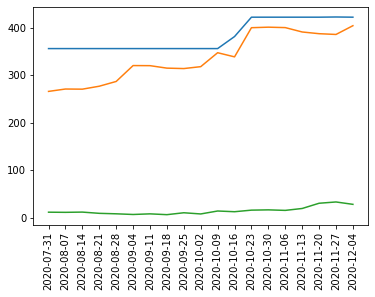

In [17]:
df_sample = df_explore[df_explore['hospital_name'] == 'OHSU HOSPITAL AND CLINICS']
plt.plot(df_sample['collection_week'], df_sample['all_adult_hospital_inpatient_beds_7_day_avg'])
plt.plot(df_sample['collection_week'], df_sample['all_adult_hospital_inpatient_bed_occupied_7_day_avg'])
plt.plot(df_sample['collection_week'], df_sample['total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg'])
plt.xticks(rotation=90)
plt.show()

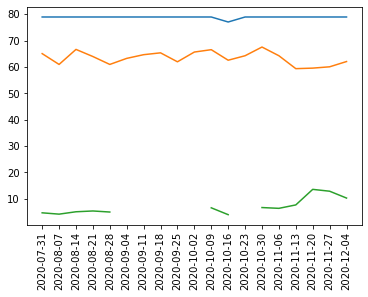

In [18]:
plt.plot(df_sample['collection_week'], df_sample['total_staffed_adult_icu_beds_7_day_avg'])
plt.plot(df_sample['collection_week'], df_sample['staffed_adult_icu_bed_occupancy_7_day_avg'])
plt.plot(df_sample['collection_week'], df_sample['staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg'])
plt.xticks(rotation=90)
plt.show()

In [19]:
df_explore.loc[(df_explore['total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg'] != -999999) & 
               (df_explore['total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg'] <
               df_explore['total_adult_patients_hospitalized_confirmed_covid_7_day_avg'])][['hospital_name', 'collection_week', 
                'total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg',
                'total_adult_patients_hospitalized_confirmed_covid_7_day_avg']]

,hospital_name,collection_week,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg,total_adult_patients_hospitalized_confirmed_covid_7_day_avg
785,RUSH FOUNDATION HOSPITAL,2020-07-31,10.3,16.3
1740,HAVASU REGIONAL MEDICAL CENTER,2020-07-31,16.0,17.4
2412,MESQUITE SPECIALTY HOSPITAL,2020-07-31,5.4,6.2
3163,HOSPITAL UNIVERSITARIO DR RUIZ ARNAU,2020-07-31,5.7,5.9
3164,BAYAMON MEDICAL CENTER,2020-07-31,7.0,9.1
...,...,...,...,...
88418,GLENWOOD REGIONAL MEDICAL CENTER,2020-12-04,38.1,672.9
89036,ELMORE COMMUNITY HOSPITAL,2020-12-04,9.1,9.6
89040,RIVERVIEW REGIONAL MEDICAL CENTER,2020-12-04,47.3,47.4
90627,HOSPITAL UNIVERSITARIO DE ADULTO,2020-12-04,9.6,12.8


Since `confirmed_and_suspected_covid` should be a subset of `confirmed_covid`, the former should always be larger than the latter. **I assume the data was simply misentered, and will use whichever value is larger but not both** 

**Reset**

In [20]:
df_explore = df.copy(deep=True)

## Estimation Logic Tree - Inpatient

Four metrics are calculated, always by `occupied_avg / avg`. I'll tackle them two at a time

For total inpatient occupancy metric:

`occupied_avg` calculation methods:
1. `'all_adult_hospital_inpatient_bed_occupied_7_day_avg'`
2. `'all_adult_hospital_inpatient_bed_occupied_7_day_sum' / 'all_adult_hospital_inpatient_bed_occupied_7_day_coverage'`
3. `'inpatient_beds_used_7_day_avg'` **<-- ESTIMATE | IF USING THEN USE ESTIMATE** `avg` **FOR CALCULATION**
4. `'inpatient_beds_used_7_day_sum' / 'inpatient_beds_used_7_day_coverage'`

`avg` calculation methods:
1. `'all_adult_hospital_inpatient_beds_7_day_avg'`
2. `'all_adult_hospital_inpatient_beds_7_day_sum' / 'all_adult_hospital_inpatient_beds_7_day_coverage'`
3. `'all_adult_hospital_beds_7_day_avg'`
4. `'all_adult_hospital_beds_7_day_sum' / 'all_adult_hospital_beds_7_day_coverage'`
5. `'total_beds_7_day_avg'` **<-- ESTIMATE | IF USING THEN USE ESTIMATE** `occupied_avg` **FOR CALCULATION**
6. `'total_beds_7_day_sum' / 'total_beds_7_day_coverage'` **<-- ESTIMATE | IF USING THEN USE ESTIMATE** `occupied_avg` **FOR CALCULATION**

For COVID inpatient occupancy metric:
    
`occupied_avg` calculation methods:
1. `'total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg'` **OR** `'total_adult_patients_hospitalized_confirmed_covid_7_day_avg'`, whichever is larger
2. `'total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum / 'total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg'` **OR**
`'total_adult_patients_hospitalized_confirmed_covid_7_day_sum' / 'total_adult_patients_hospitalized_confirmed_covid_7_day_coverage'`, whichever is larger

`avg` calculation methods:
1. `'all_adult_hospital_inpatient_beds_7_day_avg'`
2. `'all_adult_hospital_inpatient_beds_7_day_sum' / 'all_adult_hospital_inpatient_beds_7_day_coverage'`
3. `'all_adult_hospital_beds_7_day_avg'`
4. `'all_adult_hospital_beds_7_day_sum' / 'all_adult_hospital_beds_7_day_coverage'`
5. `'total_beds_7_day_avg'` **<-- ESTIMATE**
6. `'total_beds_7_day_sum' / 'total_beds_7_day_coverage'` **<-- ESTIMATE**

In [21]:
avg_cols = ['all_adult_hospital_inpatient_beds_7_day_avg', 
            'all_adult_hospital_inpatient_bed_occupied_7_day_avg', 
            'inpatient_beds_used_7_day_avg',
            'total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg',
            'total_adult_patients_hospitalized_confirmed_covid_7_day_avg',
            'total_beds_7_day_avg']

sum_cols = ['all_adult_hospital_inpatient_beds_7_day_sum', 
            'all_adult_hospital_inpatient_bed_occupied_7_day_sum', 
            'inpatient_beds_used_7_day_sum',
            'total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum',
            'total_adult_patients_hospitalized_confirmed_covid_7_day_sum',
            'total_beds_7_day_sum']

cov_cols = ['all_adult_hospital_inpatient_beds_7_day_coverage', 
            'all_adult_hospital_inpatient_bed_occupied_7_day_coverage', 
            'inpatient_beds_used_7_day_coverage',
            'total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_coverage',
            'total_adult_patients_hospitalized_confirmed_covid_7_day_coverage',
            'total_beds_7_day_coverage']

### Primary calculation method

In [22]:
for avg_col, sum_col in zip(avg_cols, sum_cols):
    print(f'{avg_col} vs. {sum_col}')
    display(df_explore.loc[lambda row: (row[avg_col] == 0) & (row[sum_col] != 0)]
            [['hospital_name', 'collection_week', avg_col, sum_col]]
           )
    display(df_explore.loc[lambda row: np.isnan(row[avg_col]) & ~np.isnan(row[sum_col])]
            [['hospital_name', 'collection_week', avg_col, sum_col]]
           )
    display(
        df_explore.loc[lambda row: (row[avg_col] == -999999) & (row[sum_col] != -999999)]
            [['hospital_name', 'collection_week', avg_col, sum_col]]
    )

all_adult_hospital_inpatient_beds_7_day_avg vs. all_adult_hospital_inpatient_beds_7_day_sum


,hospital_name,collection_week,all_adult_hospital_inpatient_beds_7_day_avg,all_adult_hospital_inpatient_beds_7_day_sum


,hospital_name,collection_week,all_adult_hospital_inpatient_beds_7_day_avg,all_adult_hospital_inpatient_beds_7_day_sum


,hospital_name,collection_week,all_adult_hospital_inpatient_beds_7_day_avg,all_adult_hospital_inpatient_beds_7_day_sum
29,COMANCHE COUNTY HOSPITAL,2020-07-31,-999999.0,4.0
40,HILLSBORO COMMUNITY HOSPITAL,2020-07-31,-999999.0,19.0
42,MEADE DISTRICT HOSPITAL,2020-07-31,-999999.0,12.0
52,NORTON COUNTY HOSPITAL,2020-07-31,-999999.0,25.0
73,OSBORNE COUNTY MEMORIAL HOSPITAL,2020-07-31,-999999.0,17.0
...,...,...,...,...
91480,PARKLAND HEALTH CENTER - BONNE TERRE,2020-12-04,-999999.0,21.0
91504,BENEFIS TETON MEDICAL CENTER,2020-12-04,-999999.0,21.0
91626,GENOA COMMUNITY HOSPITAL,2020-12-04,-999999.0,21.0
91861,EDGEWOOD SURGICAL HOSPITAL,2020-12-04,-999999.0,10.0


all_adult_hospital_inpatient_bed_occupied_7_day_avg vs. all_adult_hospital_inpatient_bed_occupied_7_day_sum


,hospital_name,collection_week,all_adult_hospital_inpatient_bed_occupied_7_day_avg,all_adult_hospital_inpatient_bed_occupied_7_day_sum


,hospital_name,collection_week,all_adult_hospital_inpatient_bed_occupied_7_day_avg,all_adult_hospital_inpatient_bed_occupied_7_day_sum


,hospital_name,collection_week,all_adult_hospital_inpatient_bed_occupied_7_day_avg,all_adult_hospital_inpatient_bed_occupied_7_day_sum
1,EDWARDS COUNTY HOSPITAL,2020-07-31,-999999.0,4.0
21,MERCY SPECIALTY HOSPITAL SOUTHEAST KANSAS,2020-07-31,-999999.0,25.0
22,MERCY HOSPITAL COLUMBUS,2020-07-31,-999999.0,7.0
29,COMANCHE COUNTY HOSPITAL,2020-07-31,-999999.0,5.0
34,SATANTA DISTRICT HOSPITAL,2020-07-31,-999999.0,5.0
...,...,...,...,...
92185,KINGS DAUGHTERS MEDICAL CENTER OHIO,2020-12-04,-999999.0,14.0
92203,COMMUNITY MEMORIAL HOSPITAL,2020-12-04,-999999.0,15.0
92207,DILEY RIDGE MEDICAL CENTER,2020-12-04,-999999.0,27.0
92221,RAINBOW BABIES AND CHILDRENS HOSPITAL,2020-12-04,-999999.0,25.0


inpatient_beds_used_7_day_avg vs. inpatient_beds_used_7_day_sum


,hospital_name,collection_week,inpatient_beds_used_7_day_avg,inpatient_beds_used_7_day_sum


,hospital_name,collection_week,inpatient_beds_used_7_day_avg,inpatient_beds_used_7_day_sum


,hospital_name,collection_week,inpatient_beds_used_7_day_avg,inpatient_beds_used_7_day_sum
1,EDWARDS COUNTY HOSPITAL,2020-07-31,-999999.0,4.0
15,GRAHAM COUNTY HOSPITAL,2020-07-31,-999999.0,8.0
21,MERCY SPECIALTY HOSPITAL SOUTHEAST KANSAS,2020-07-31,-999999.0,25.0
22,MERCY HOSPITAL COLUMBUS,2020-07-31,-999999.0,7.0
23,CHEYENNE COUNTY HOSPITAL,2020-07-31,-999999.0,12.0
...,...,...,...,...
92166,TRINITY HOSPITAL TWIN CITY,2020-12-04,-999999.0,27.0
92185,KINGS DAUGHTERS MEDICAL CENTER OHIO,2020-12-04,-999999.0,14.0
92203,COMMUNITY MEMORIAL HOSPITAL,2020-12-04,-999999.0,15.0
92207,DILEY RIDGE MEDICAL CENTER,2020-12-04,-999999.0,27.0


total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg vs. total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum


,hospital_name,collection_week,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum


,hospital_name,collection_week,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum


,hospital_name,collection_week,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum
0,"ROY LESTER SCHNEIDER HOSPITAL,THE",2020-07-31,-999999.0,21.0
2,HAYS MEDICAL CENTER,2020-07-31,-999999.0,15.0
4,ST CATHERINE HOSPITAL,2020-07-31,-999999.0,10.0
5,ADVENTHEALTH OTTAWA,2020-07-31,-999999.0,22.0
6,GEARY COMMUNITY HOSPITAL,2020-07-31,-999999.0,10.0
...,...,...,...,...
92240,"HENRY COUNTY HOSPITAL, INC",2020-12-04,-999999.0,19.0
92246,MERCY HEALTH - WILLARD HOSPITAL,2020-12-04,-999999.0,5.0
92247,CINCINNATI CHILDREN'S HOSPITAL MEDICAL CENTER,2020-12-04,-999999.0,18.0
92255,JAMES CANCER HOSPITAL & SOLOVE RESEARCH INSTITUTE,2020-12-04,-999999.0,5.0


total_adult_patients_hospitalized_confirmed_covid_7_day_avg vs. total_adult_patients_hospitalized_confirmed_covid_7_day_sum


,hospital_name,collection_week,total_adult_patients_hospitalized_confirmed_covid_7_day_avg,total_adult_patients_hospitalized_confirmed_covid_7_day_sum


,hospital_name,collection_week,total_adult_patients_hospitalized_confirmed_covid_7_day_avg,total_adult_patients_hospitalized_confirmed_covid_7_day_sum


,hospital_name,collection_week,total_adult_patients_hospitalized_confirmed_covid_7_day_avg,total_adult_patients_hospitalized_confirmed_covid_7_day_sum
0,"ROY LESTER SCHNEIDER HOSPITAL,THE",2020-07-31,-999999.0,21.0
2,HAYS MEDICAL CENTER,2020-07-31,-999999.0,15.0
4,ST CATHERINE HOSPITAL,2020-07-31,-999999.0,7.0
5,ADVENTHEALTH OTTAWA,2020-07-31,-999999.0,5.0
6,GEARY COMMUNITY HOSPITAL,2020-07-31,-999999.0,10.0
...,...,...,...,...
92211,LUTHERAN HOSPITAL,2020-12-04,-999999.0,10.0
92219,REGENCY HOSPITAL OF CLEVELAND EAST,2020-12-04,-999999.0,6.0
92240,"HENRY COUNTY HOSPITAL, INC",2020-12-04,-999999.0,16.0
92246,MERCY HEALTH - WILLARD HOSPITAL,2020-12-04,-999999.0,4.0


total_beds_7_day_avg vs. total_beds_7_day_sum


,hospital_name,collection_week,total_beds_7_day_avg,total_beds_7_day_sum


,hospital_name,collection_week,total_beds_7_day_avg,total_beds_7_day_sum


,hospital_name,collection_week,total_beds_7_day_avg,total_beds_7_day_sum
1276,SURPRISE VALLEY COMMUNITY HOSPITAL,2020-07-31,-999999.0,12.0
1769,EUREKA SPRINGS HOSPITAL COMMISSION,2020-07-31,-999999.0,8.0
1851,NORTHRIDGE MEDICAL CENTER,2020-07-31,-999999.0,4.0
2628,ASPIRE HOSPITAL,2020-07-31,-999999.0,5.0
2642,"WOMANS HOSPITAL OF TEXAS,THE",2020-07-31,-999999.0,24.0
...,...,...,...,...
85026,FOUNDATION SURGICAL HOSPITAL OF SAN ANTONIO,2020-11-27,-999999.0,14.0
86458,SHRINERS HOSPITALS FOR CHILDREN,2020-11-27,-999999.0,20.0
88960,PROVIDENCE VALDEZ MEDICAL CENTER,2020-12-04,-999999.0,15.0
89918,FOUNDATION SURGICAL HOSPITAL OF SAN ANTONIO,2020-12-04,-999999.0,14.0


If the `avg` is `nan` or `0`, then the `sum` is also `nan` or `0`.

However, there are conditions where `avg` is `-999999` but `sum` is not. In these cases, use `sum` and `coverage` to calculate `avg`

Therefore, if `avg` is `-999999`, use `sum/coverage`. If `avg` is `nan` or `0` we skip using `sum/coverage` and move to using an estimation method

In [23]:
for avg_col, sum_col in zip(avg_cols, sum_cols):
    print(f'{avg_col} vs. {sum_col}')
    display(
        df_explore.loc[lambda row: (row[sum_col] == 0) & (row[avg_col] != 0)]
            [['hospital_name', 'collection_week', sum_col, avg_col]]
    )
    display(
        df_explore.loc[lambda row: np.isnan(row[sum_col]) & ~np.isnan(row[avg_col])]
            [['hospital_name', 'collection_week', sum_col, avg_col]]
    )
    display(
        df_explore.loc[lambda row: (row[sum_col] == -999999) & (row[avg_col] != -999999)]
            [['hospital_name', 'collection_week', sum_col, avg_col]]
    )

all_adult_hospital_inpatient_beds_7_day_avg vs. all_adult_hospital_inpatient_beds_7_day_sum


,hospital_name,collection_week,all_adult_hospital_inpatient_beds_7_day_sum,all_adult_hospital_inpatient_beds_7_day_avg


,hospital_name,collection_week,all_adult_hospital_inpatient_beds_7_day_sum,all_adult_hospital_inpatient_beds_7_day_avg


,hospital_name,collection_week,all_adult_hospital_inpatient_beds_7_day_sum,all_adult_hospital_inpatient_beds_7_day_avg


all_adult_hospital_inpatient_bed_occupied_7_day_avg vs. all_adult_hospital_inpatient_bed_occupied_7_day_sum


,hospital_name,collection_week,all_adult_hospital_inpatient_bed_occupied_7_day_sum,all_adult_hospital_inpatient_bed_occupied_7_day_avg


,hospital_name,collection_week,all_adult_hospital_inpatient_bed_occupied_7_day_sum,all_adult_hospital_inpatient_bed_occupied_7_day_avg


,hospital_name,collection_week,all_adult_hospital_inpatient_bed_occupied_7_day_sum,all_adult_hospital_inpatient_bed_occupied_7_day_avg


inpatient_beds_used_7_day_avg vs. inpatient_beds_used_7_day_sum


,hospital_name,collection_week,inpatient_beds_used_7_day_sum,inpatient_beds_used_7_day_avg


,hospital_name,collection_week,inpatient_beds_used_7_day_sum,inpatient_beds_used_7_day_avg


,hospital_name,collection_week,inpatient_beds_used_7_day_sum,inpatient_beds_used_7_day_avg


total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg vs. total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum


,hospital_name,collection_week,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg


,hospital_name,collection_week,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg


,hospital_name,collection_week,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg


total_adult_patients_hospitalized_confirmed_covid_7_day_avg vs. total_adult_patients_hospitalized_confirmed_covid_7_day_sum


,hospital_name,collection_week,total_adult_patients_hospitalized_confirmed_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_covid_7_day_avg


,hospital_name,collection_week,total_adult_patients_hospitalized_confirmed_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_covid_7_day_avg


,hospital_name,collection_week,total_adult_patients_hospitalized_confirmed_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_covid_7_day_avg


total_beds_7_day_avg vs. total_beds_7_day_sum


,hospital_name,collection_week,total_beds_7_day_sum,total_beds_7_day_avg


,hospital_name,collection_week,total_beds_7_day_sum,total_beds_7_day_avg


,hospital_name,collection_week,total_beds_7_day_sum,total_beds_7_day_avg


If `sum` is `-999999`, `0`, or `nan`, then `avg` follows.

Therefore, there if we fail to get a number from `avg`, we do not need to come back to `avg`. There is no condition where `avg` will take precedence over a `sum/coverage` metric

### Sum/Coverage 

Main concern is if coverage is 0

In [24]:
for col in cov_cols:
    print(f'Min: {df_explore[col].min()} | Max: {df_explore[col].max()}') #check for -999999
    print(df_explore[col].isnull().any()) #check for NaN

Min: 0 | Max: 7
False
Min: 0 | Max: 7
False
Min: 0 | Max: 7
False
Min: 0 | Max: 7
False
Min: 0 | Max: 7
False
Min: 0 | Max: 7
False


This simplifies the coding - we only need to check for `coverage=0` condition

In [25]:
for sum_col, cov_col in zip(sum_cols, cov_cols):
    print(f'{sum_col} vs. {cov_col}')
    display(
        df_explore.loc[lambda row: (row[cov_col] == 0) & ~(np.isin(row[sum_col], [0, -999999]) | np.isnan(row[sum_col]))]
                      [['hospital_name', 'collection_week', cov_col, sum_col]]
    )

all_adult_hospital_inpatient_beds_7_day_sum vs. all_adult_hospital_inpatient_beds_7_day_coverage


,hospital_name,collection_week,all_adult_hospital_inpatient_beds_7_day_coverage,all_adult_hospital_inpatient_beds_7_day_sum


all_adult_hospital_inpatient_bed_occupied_7_day_sum vs. all_adult_hospital_inpatient_bed_occupied_7_day_coverage


,hospital_name,collection_week,all_adult_hospital_inpatient_bed_occupied_7_day_coverage,all_adult_hospital_inpatient_bed_occupied_7_day_sum


inpatient_beds_used_7_day_sum vs. inpatient_beds_used_7_day_coverage


,hospital_name,collection_week,inpatient_beds_used_7_day_coverage,inpatient_beds_used_7_day_sum


total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum vs. total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_coverage


,hospital_name,collection_week,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_coverage,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum


total_adult_patients_hospitalized_confirmed_covid_7_day_sum vs. total_adult_patients_hospitalized_confirmed_covid_7_day_coverage


,hospital_name,collection_week,total_adult_patients_hospitalized_confirmed_covid_7_day_coverage,total_adult_patients_hospitalized_confirmed_covid_7_day_sum


total_beds_7_day_sum vs. total_beds_7_day_coverage


,hospital_name,collection_week,total_beds_7_day_coverage,total_beds_7_day_sum


If `coverage` is `0`, then the sum is `0`, `nan`, or `-999999`. 

In [26]:
for sum_col, cov_col in zip(sum_cols, cov_cols):
    print(f'{sum_col} vs. {cov_col}')
    display(
        df_explore.loc[lambda row: (row[cov_col] == 0)][sum_col].unique()
    )

all_adult_hospital_inpatient_beds_7_day_sum vs. all_adult_hospital_inpatient_beds_7_day_coverage


array([nan])

all_adult_hospital_inpatient_bed_occupied_7_day_sum vs. all_adult_hospital_inpatient_bed_occupied_7_day_coverage


array([nan])

inpatient_beds_used_7_day_sum vs. inpatient_beds_used_7_day_coverage


array([nan])

total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum vs. total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_coverage


array([nan])

total_adult_patients_hospitalized_confirmed_covid_7_day_sum vs. total_adult_patients_hospitalized_confirmed_covid_7_day_coverage


array([nan])

total_beds_7_day_sum vs. total_beds_7_day_coverage


array([nan])

If `coverage` is `0`, then the sum is **always** `nan`.

Therefore, if the coverage is `0` then we just skip the `sum/coverage` and move on. If we reached the end of the logic tree, mark the value as `nan`

In [27]:
for sum_col, cov_col in zip(sum_cols, cov_cols):
    print(f'{sum_col} vs. {cov_col}')
    display(
        df_explore.loc[lambda row: (row[cov_col] != 0) & np.isin(row[sum_col],[0,-999999])]
        [['hospital_name', 'collection_week', cov_col, sum_col]]
    )

all_adult_hospital_inpatient_beds_7_day_sum vs. all_adult_hospital_inpatient_beds_7_day_coverage


,hospital_name,collection_week,all_adult_hospital_inpatient_beds_7_day_coverage,all_adult_hospital_inpatient_beds_7_day_sum
1,EDWARDS COUNTY HOSPITAL,2020-07-31,2,0.0
26,CLAY COUNTY MEDICAL CENTER,2020-07-31,5,0.0
59,CHILDREN'S MERCY HOSPITAL KANSAS,2020-07-31,7,0.0
69,SAINT LUKE'S CUSHING HOSPITAL,2020-07-31,7,0.0
334,PINCKNEYVILLE COMMUNITY HOSPITAL,2020-07-31,5,0.0
...,...,...,...,...
92097,HIGHLANDS CASHIERS HOSPITAL,2020-12-04,7,0.0
92212,CLEVELAND CLINIC CHILDREN'S HOSPITAL FOR REHAB,2020-12-04,7,0.0
92229,NATIONWIDE CHILDREN'S HOSPITAL,2020-12-04,7,0.0
92247,CINCINNATI CHILDREN'S HOSPITAL MEDICAL CENTER,2020-12-04,7,0.0


all_adult_hospital_inpatient_bed_occupied_7_day_sum vs. all_adult_hospital_inpatient_bed_occupied_7_day_coverage


,hospital_name,collection_week,all_adult_hospital_inpatient_bed_occupied_7_day_coverage,all_adult_hospital_inpatient_bed_occupied_7_day_sum
33,GIRARD MEDICAL CENTER,2020-07-31,1,-999999.0
59,CHILDREN'S MERCY HOSPITAL KANSAS,2020-07-31,7,0.0
69,SAINT LUKE'S CUSHING HOSPITAL,2020-07-31,7,0.0
84,MERCYONE PRIMGHAR MEDICAL CENTER,2020-07-31,7,-999999.0
203,ASSUMPTION COMMUNITY HOSPITAL,2020-07-31,5,0.0
...,...,...,...,...
92131,DAYTON CHILDRENS HOSPITAL,2020-12-04,7,-999999.0
92212,CLEVELAND CLINIC CHILDREN'S HOSPITAL FOR REHAB,2020-12-04,7,0.0
92229,NATIONWIDE CHILDREN'S HOSPITAL,2020-12-04,7,0.0
92247,CINCINNATI CHILDREN'S HOSPITAL MEDICAL CENTER,2020-12-04,7,0.0


inpatient_beds_used_7_day_sum vs. inpatient_beds_used_7_day_coverage


,hospital_name,collection_week,inpatient_beds_used_7_day_coverage,inpatient_beds_used_7_day_sum
18,DECATUR COUNTY HOSPITAL,2020-07-31,7,-999999.0
33,GIRARD MEDICAL CENTER,2020-07-31,1,-999999.0
69,SAINT LUKE'S CUSHING HOSPITAL,2020-07-31,7,0.0
84,MERCYONE PRIMGHAR MEDICAL CENTER,2020-07-31,3,-999999.0
203,ASSUMPTION COMMUNITY HOSPITAL,2020-07-31,5,0.0
...,...,...,...,...
91861,EDGEWOOD SURGICAL HOSPITAL,2020-12-04,5,-999999.0
91965,LINTON HOSPITAL - CAH,2020-12-04,7,-999999.0
92011,EAST OHIO REGIONAL HOSPITAL,2020-12-04,7,0.0
92097,HIGHLANDS CASHIERS HOSPITAL,2020-12-04,7,0.0


total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum vs. total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_coverage


,hospital_name,collection_week,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_coverage,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum
1,EDWARDS COUNTY HOSPITAL,2020-07-31,2,0.0
8,GOVE COUNTY MEDICAL CENTER,2020-07-31,5,0.0
9,BOB WILSON MEMORIAL GRANT COUNTY HOSPITAL,2020-07-31,7,-999999.0
10,GREELEY COUNTY HEALTH SERVICES,2020-07-31,7,0.0
12,HAMILTON COUNTY HOSPITAL,2020-07-31,2,-999999.0
...,...,...,...,...
92250,TRIHEALTH EVENDALE HOSPITAL,2020-12-04,7,0.0
92256,MOUNT CARMEL NEW ALBANY SURGICAL HOSPITAL,2020-12-04,7,0.0
92261,GREENE MEMORIAL HOSPITAL,2020-12-04,7,0.0
92264,SHRINERS HOSPITALS FOR CHILDREN - CINCINNATI,2020-12-04,7,0.0


total_adult_patients_hospitalized_confirmed_covid_7_day_sum vs. total_adult_patients_hospitalized_confirmed_covid_7_day_coverage


,hospital_name,collection_week,total_adult_patients_hospitalized_confirmed_covid_7_day_coverage,total_adult_patients_hospitalized_confirmed_covid_7_day_sum
1,EDWARDS COUNTY HOSPITAL,2020-07-31,2,0.0
8,GOVE COUNTY MEDICAL CENTER,2020-07-31,5,0.0
9,BOB WILSON MEMORIAL GRANT COUNTY HOSPITAL,2020-07-31,7,0.0
12,HAMILTON COUNTY HOSPITAL,2020-07-31,2,-999999.0
13,PATTERSON HEALTH CENTER,2020-07-31,1,-999999.0
...,...,...,...,...
92255,JAMES CANCER HOSPITAL & SOLOVE RESEARCH INSTITUTE,2020-12-04,7,-999999.0
92256,MOUNT CARMEL NEW ALBANY SURGICAL HOSPITAL,2020-12-04,7,0.0
92261,GREENE MEMORIAL HOSPITAL,2020-12-04,7,0.0
92264,SHRINERS HOSPITALS FOR CHILDREN - CINCINNATI,2020-12-04,7,0.0


total_beds_7_day_sum vs. total_beds_7_day_coverage


,hospital_name,collection_week,total_beds_7_day_coverage,total_beds_7_day_sum
1242,GEORGE L MEE MEMORIAL HOSPITAL,2020-07-31,6,0.0
1332,GLENDORA OAKS BEHAVIORAL HEALTH HOSPITAL,2020-07-31,6,0.0
1599,Surgery Center of Zachary,2020-07-31,5,0.0
1613,HonorHealth Sonoran Emergency Center,2020-07-31,6,0.0
1804,SONOMA SPECIALTY HOSPITAL,2020-07-31,7,0.0
...,...,...,...,...
90884,TEXAS HEALTH SPECIALTY HOSPITAL FORT WORTH,2020-12-04,7,-999999.0
91256,HEALTHALLIANCE HOSPITAL MARY'S AVENUE CAMPUS,2020-12-04,7,0.0
91769,INTEGRIS BASS PAVILION,2020-12-04,7,0.0
92011,EAST OHIO REGIONAL HOSPITAL,2020-12-04,7,0.0


If coverage is not `0`, sum can be `0` or `-999999` but **not** `nan`. 

If sum is `0` or `-999999`, do we use `sum/coverage` value or move to the next set of values to estimate the metric?

- Numerator, **total inpatient occupancy** metric: moving from `sum/coverage` to `avg` immediately precipitates estimation. This should be investigated, as estimated value measures something different
- Numerator, **COVID inpatient occupancy** metric: logic tree does not move from a `sum/coverage` to `avg` evaluation condition.
- Denominator, both metrics: value cannot be `0`. 

In [28]:
sum_col = 'all_adult_hospital_inpatient_bed_occupied_7_day_sum'
cov_col = 'all_adult_hospital_inpatient_bed_occupied_7_day_coverage'
from_col = 'all_adult_hospital_inpatient_bed_occupied_7_day_avg'
to_col = 'inpatient_beds_used_7_day_avg'
display(
    df_explore.loc[lambda row: (row[sum_col] == 0)]
    [['hospital_name', 'hospital_subtype', 'collection_week', from_col, sum_col, cov_col, to_col]]
)

,hospital_name,hospital_subtype,collection_week,all_adult_hospital_inpatient_bed_occupied_7_day_avg,all_adult_hospital_inpatient_bed_occupied_7_day_sum,all_adult_hospital_inpatient_bed_occupied_7_day_coverage,inpatient_beds_used_7_day_avg
59,CHILDREN'S MERCY HOSPITAL KANSAS,Childrens Hospitals,2020-07-31,0.0,0.0,7,5.0
69,SAINT LUKE'S CUSHING HOSPITAL,Short Term,2020-07-31,0.0,0.0,7,0.0
203,ASSUMPTION COMMUNITY HOSPITAL,Critical Access Hospitals,2020-07-31,0.0,0.0,5,0.0
205,Prairieville Family Hospital,Short Term,2020-07-31,0.0,0.0,5,0.0
222,PREVOST MEMORIAL HOSPITAL,Critical Access Hospitals,2020-07-31,0.0,0.0,5,0.0
...,...,...,...,...,...,...,...
92097,HIGHLANDS CASHIERS HOSPITAL,Critical Access Hospitals,2020-12-04,0.0,0.0,7,0.0
92212,CLEVELAND CLINIC CHILDREN'S HOSPITAL FOR REHAB,Childrens Hospitals,2020-12-04,0.0,0.0,7,13.7
92229,NATIONWIDE CHILDREN'S HOSPITAL,Childrens Hospitals,2020-12-04,0.0,0.0,7,356.9
92247,CINCINNATI CHILDREN'S HOSPITAL MEDICAL CENTER,Childrens Hospitals,2020-12-04,0.0,0.0,7,289.1


Need to filter dataset and exclude Children's hospitals

In [29]:
avg_col = 'all_adult_hospital_inpatient_bed_occupied_7_day_avg'
from_col = 'all_adult_hospital_inpatient_bed_occupied_7_day_sum'
to_col = 'inpatient_beds_used_7_day_avg'
display(
    df_explore.loc[lambda row: (row['hospital_subtype'] != "Childrens Hospitals") & (row[from_col] == 0) & (row[to_col] != 0)]
    [['hospital_name', 'collection_week', avg_col, from_col, to_col, 
      'total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg',
      'total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg']]
)

,hospital_name,collection_week,all_adult_hospital_inpatient_bed_occupied_7_day_avg,all_adult_hospital_inpatient_bed_occupied_7_day_sum,inpatient_beds_used_7_day_avg,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg,total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg
574,INDIANA UNIVERSITY HEALTH PAOLI HOSPITAL,2020-07-31,0.0,0.0,-999999.0,0.0,0.0
848,PERHAM HEALTH,2020-07-31,0.0,0.0,-999999.0,0.0,0.0
1114,SPARROW CLINTON HOSPITAL,2020-07-31,0.0,0.0,13.0,-999999.0,-999999.0
2051,MITCHELL COUNTY HOSPITAL,2020-07-31,0.0,0.0,14.1,NaN,NaN
2234,WEISBROD MEMORIAL COUNTY HOSPITAL,2020-07-31,0.0,0.0,20.0,0.0,0.0
...,...,...,...,...,...,...,...
90610,POWELL VALLEY HOSPITAL,2020-12-04,0.0,0.0,9.6,0.0,0.0
90617,WESTON COUNTY HEALTH SERVICES,2020-12-04,0.0,0.0,7.7,0.0,0.0
90661,HOT SPRINGS COUNTY MEMORIAL HOSPITAL,2020-12-04,0.0,0.0,4.3,0.0,0.0
91664,ROGER MILLS MEMORIAL HOSPITAL,2020-12-04,0.0,0.0,-999999.0,0.0,0.0


I don't believe that the sum can realistically be 0 outside of children hospitals. 

**Therefore, if the sum/coverage value is 0, we will move on**

In [30]:
avg_col = 'all_adult_hospital_inpatient_bed_occupied_7_day_avg'
from_col = 'all_adult_hospital_inpatient_bed_occupied_7_day_sum'
to_col = 'inpatient_beds_used_7_day_avg'
display(
    df_explore.loc[lambda row: (row['hospital_subtype'] != "Childrens Hospitals") & (row[from_col] == -999999) & (row[to_col] != -999999)]
    [['hospital_name', 'collection_week', avg_col, from_col, to_col, 
      'total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg',
      'total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg']]
)

,hospital_name,collection_week,all_adult_hospital_inpatient_bed_occupied_7_day_avg,all_adult_hospital_inpatient_bed_occupied_7_day_sum,inpatient_beds_used_7_day_avg,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg,total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg
285,BOURBON COMMUNITY HOSPITAL,2020-07-31,-999999.0,-999999.0,4.0,0.0,0.0
900,SANFORD CANBY MEDICAL CENTER,2020-07-31,-999999.0,-999999.0,5.7,0.0,0.0
5435,SANFORD BAGLEY MEDICAL CENTER,2020-08-07,-999999.0,-999999.0,5.6,0.0,0.0
5701,SANFORD CANBY MEDICAL CENTER,2020-08-07,-999999.0,-999999.0,8.0,0.0,0.0
5703,SANFORD MEDICAL CENTER WHEATON,2020-08-07,-999999.0,-999999.0,4.6,0.0,0.0
7581,SANFORD CLEAR LAKE MEDICAL CENTER,2020-08-07,-999999.0,-999999.0,5.6,0.0,0.0
8077,ST CROIX REGIONAL MEDICAL CENTER,2020-08-07,-999999.0,-999999.0,7.0,0.0,0.0
10250,SANFORD BAGLEY MEDICAL CENTER,2020-08-14,-999999.0,-999999.0,5.1,-999999.0,0.0
12899,SOUTH BIG HORN COUNTY CRITICAL ACCESS HOSPITAL,2020-08-14,-999999.0,-999999.0,4.6,0.0,0.0
13984,BUCKTAIL MEDICAL CENTER,2020-08-14,-999999.0,-999999.0,8.9,0.0,0.0


Seems like if the sum is redacted, inpatient count is generally very low (close to 4). The presence of a child patient could account for these values. There are a few outliers, but a quick search concludes that these outlier hospitals emphasize pediatric health. If they are redacting, I am giving them the benefit of the doubt and assume it is truly for privacy and not as a easy way to mask data.

Therefore, if sum is `-999999`, assume it is `4` given the conditions of redaction.

Summary: 

- If `avg` is `nan` or `0` we can skip using `sum/coverage` and immediately move to using an estimation method
- If `avg` is `-999999`, use `sum/coverage`. 

- If the coverage is `0` then we just skip the `sum/coverage` and move on. If we reached the end of the logic, mark the value as `nan`.
- If coverage is not `0`, sum cannot be `nan`.
- If the sum is `0`, move to the next set of values and estimate the metric. If we reached the end of the logic tree, mark the value as `0`
- If the sum is `-999999`, replace the sum value with a value of `4`

## ICU

For total icu occupancy metric:

`occupied_avg` calculation methods:
1. `'staffed_adult_icu_bed_occupancy_7_day_avg'`
2. `'staffed_adult_icu_bed_occupancy_7_day_sum' / 'staffed_adult_icu_bed_occupancy_7_day_coverage'`
3. `'icu_beds_used_7_day_avg'` **<-- ESTIMATE | IF USING THEN USE ESTIMATE** `avg` **FOR CALCULATION**
4. `'icu_beds_used_7_day_sum' / 'icu_beds_used_7_day_coverage'`

`avg` calculation methods:
1. `'total_staffed_adult_icu_beds_7_day_avg'`
2. `'total_staffed_adult_icu_beds_7_day_sum' / 'total_staffed_adult_icu_beds_7_day_coverage'`
3. `'total_icu_beds_7_day_avg'` **<-- ESTIMATE | IF USING THEN USE ESTIMATE** `occupied_avg` **FOR CALCULATION**
4. `'total_icu_beds_7_day_sum' / 'total_icu_beds_7_day_coverage'` **<-- ESTIMATE | IF USING THEN USE ESTIMATE** `occupied_avg` **FOR CALCULATION**

For COVID inpatient occupancy metric:
    
`occupied_avg` calculation methods:
1. `'staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg'` **OR** `'staffed_icu_adult_patients_confirmed_covid_7_day_avg'`, whichever is larger
2. `'staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum / 'staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_coverage'` **OR**
`'staffed_icu_adult_patients_confirmed_covid_7_day_sum' / 'staffed_icu_adult_patients_confirmed_covid_7_day_coverage'`, whichever is larger

`avg` calculation methods:
1. `'total_staffed_adult_icu_beds_7_day_avg'`
2. `'total_staffed_adult_icu_beds_7_day_sum' / 'total_staffed_adult_icu_beds_7_day_coverage'`
3. `'total_icu_beds_7_day_avg'` **<-- ESTIMATE | IF USING THEN USE ESTIMATE** `occupied_avg` **FOR CALCULATION**
4. `'total_icu_beds_7_day_sum' / 'total_icu_beds_7_day_coverage'` **<-- ESTIMATE | IF USING THEN USE ESTIMATE** `occupied_avg` **FOR CALCULATION**

In [31]:
avg_cols = ['total_staffed_adult_icu_beds_7_day_avg', 
            'staffed_adult_icu_bed_occupancy_7_day_avg', 
            'icu_beds_used_7_day_avg',
            'staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg',
            'staffed_icu_adult_patients_confirmed_covid_7_day_avg',
            'total_icu_beds_7_day_avg']

sum_cols = ['total_staffed_adult_icu_beds_7_day_sum', 
            'staffed_adult_icu_bed_occupancy_7_day_sum', 
            'icu_beds_used_7_day_sum',
            'staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum',
            'staffed_icu_adult_patients_confirmed_covid_7_day_sum',
            'total_icu_beds_7_day_sum']

cov_cols = ['total_staffed_adult_icu_beds_7_day_coverage', 
            'staffed_adult_icu_bed_occupancy_7_day_coverage', 
            'icu_beds_used_7_day_coverage',
            'staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_coverage',
            'staffed_icu_adult_patients_confirmed_covid_7_day_coverage',
            'total_icu_beds_7_day_coverage']

### Primary calculation method

In [32]:
for avg_col, sum_col in zip(avg_cols, sum_cols):
    print(f'{avg_col} vs. {sum_col}')
    display(df_explore.loc[lambda row: (row[avg_col] == 0) & (row[sum_col] != 0)]
            [['hospital_name', 'collection_week', avg_col, sum_col]]
           )
    display(df_explore.loc[lambda row: np.isnan(row[avg_col]) & ~np.isnan(row[sum_col])]
            [['hospital_name', 'collection_week', avg_col, sum_col]]
           )
    display(
        df_explore.loc[lambda row: (row[avg_col] == -999999) & (row[sum_col] != -999999)]
            [['hospital_name', 'collection_week', avg_col, sum_col]]
    )

total_staffed_adult_icu_beds_7_day_avg vs. total_staffed_adult_icu_beds_7_day_sum


,hospital_name,collection_week,total_staffed_adult_icu_beds_7_day_avg,total_staffed_adult_icu_beds_7_day_sum


,hospital_name,collection_week,total_staffed_adult_icu_beds_7_day_avg,total_staffed_adult_icu_beds_7_day_sum


,hospital_name,collection_week,total_staffed_adult_icu_beds_7_day_avg,total_staffed_adult_icu_beds_7_day_sum
70,SAINT JOHN HOSPITAL,2020-07-31,-999999.0,19.0
74,HIAWATHA COMMUNITY HOSPITAL,2020-07-31,-999999.0,4.0
80,BURGESS HEALTH CENTER,2020-07-31,-999999.0,12.0
82,MAHASKA HEALTH PARTNERSHIP,2020-07-31,-999999.0,13.0
87,SHENANDOAH MEDICAL CENTER,2020-07-31,-999999.0,14.0
...,...,...,...,...
92185,KINGS DAUGHTERS MEDICAL CENTER OHIO,2020-12-04,-999999.0,7.0
92201,MERCY HEALTH - DEFIANCE HOSPITAL,2020-12-04,-999999.0,7.0
92203,COMMUNITY MEMORIAL HOSPITAL,2020-12-04,-999999.0,14.0
92238,HARDIN MEMORIAL HOSPITAL,2020-12-04,-999999.0,25.0


staffed_adult_icu_bed_occupancy_7_day_avg vs. staffed_adult_icu_bed_occupancy_7_day_sum


,hospital_name,collection_week,staffed_adult_icu_bed_occupancy_7_day_avg,staffed_adult_icu_bed_occupancy_7_day_sum


,hospital_name,collection_week,staffed_adult_icu_bed_occupancy_7_day_avg,staffed_adult_icu_bed_occupancy_7_day_sum


,hospital_name,collection_week,staffed_adult_icu_bed_occupancy_7_day_avg,staffed_adult_icu_bed_occupancy_7_day_sum
14,NEWTON MEDICAL CENTER,2020-07-31,-999999.0,14.0
44,MITCHELL COUNTY HOSPITAL HEALTH SYSTEMS,2020-07-31,-999999.0,5.0
45,"COFFEYVILLE REGIONAL MEDICAL CENTER, INC",2020-07-31,-999999.0,15.0
49,NEOSHO MEMORIAL REGIONAL MEDICAL CENTER,2020-07-31,-999999.0,23.0
70,SAINT JOHN HOSPITAL,2020-07-31,-999999.0,19.0
...,...,...,...,...
92208,FAYETTE COUNTY MEMORIAL HOSPITAL,2020-12-04,-999999.0,11.0
92240,"HENRY COUNTY HOSPITAL, INC",2020-12-04,-999999.0,17.0
92243,HOCKING VALLEY COMMUNITY HOSPITAL,2020-12-04,-999999.0,24.0
92244,POMERENE HOSPITAL,2020-12-04,-999999.0,5.0


icu_beds_used_7_day_avg vs. icu_beds_used_7_day_sum


,hospital_name,collection_week,icu_beds_used_7_day_avg,icu_beds_used_7_day_sum


,hospital_name,collection_week,icu_beds_used_7_day_avg,icu_beds_used_7_day_sum


,hospital_name,collection_week,icu_beds_used_7_day_avg,icu_beds_used_7_day_sum
6,GEARY COMMUNITY HOSPITAL,2020-07-31,-999999.0,12.0
14,NEWTON MEDICAL CENTER,2020-07-31,-999999.0,14.0
31,WILLIAM NEWTON HOSPITAL,2020-07-31,-999999.0,7.0
44,MITCHELL COUNTY HOSPITAL HEALTH SYSTEMS,2020-07-31,-999999.0,5.0
45,"COFFEYVILLE REGIONAL MEDICAL CENTER, INC",2020-07-31,-999999.0,17.0
...,...,...,...,...
92208,FAYETTE COUNTY MEMORIAL HOSPITAL,2020-12-04,-999999.0,11.0
92240,"HENRY COUNTY HOSPITAL, INC",2020-12-04,-999999.0,17.0
92243,HOCKING VALLEY COMMUNITY HOSPITAL,2020-12-04,-999999.0,24.0
92244,POMERENE HOSPITAL,2020-12-04,-999999.0,5.0


staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg vs. staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum


,hospital_name,collection_week,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum


,hospital_name,collection_week,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum


,hospital_name,collection_week,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum
0,"ROY LESTER SCHNEIDER HOSPITAL,THE",2020-07-31,-999999.0,14.0
2,HAYS MEDICAL CENTER,2020-07-31,-999999.0,14.0
5,ADVENTHEALTH OTTAWA,2020-07-31,-999999.0,6.0
6,GEARY COMMUNITY HOSPITAL,2020-07-31,-999999.0,7.0
7,LAWRENCE MEMORIAL HOSPITAL,2020-07-31,-999999.0,4.0
...,...,...,...,...
92243,HOCKING VALLEY COMMUNITY HOSPITAL,2020-12-04,-999999.0,18.0
92244,POMERENE HOSPITAL,2020-12-04,-999999.0,5.0
92247,CINCINNATI CHILDREN'S HOSPITAL MEDICAL CENTER,2020-12-04,-999999.0,6.0
92254,DUBLIN METHODIST HOSPITAL,2020-12-04,-999999.0,25.0


staffed_icu_adult_patients_confirmed_covid_7_day_avg vs. staffed_icu_adult_patients_confirmed_covid_7_day_sum


,hospital_name,collection_week,staffed_icu_adult_patients_confirmed_covid_7_day_avg,staffed_icu_adult_patients_confirmed_covid_7_day_sum


,hospital_name,collection_week,staffed_icu_adult_patients_confirmed_covid_7_day_avg,staffed_icu_adult_patients_confirmed_covid_7_day_sum


,hospital_name,collection_week,staffed_icu_adult_patients_confirmed_covid_7_day_avg,staffed_icu_adult_patients_confirmed_covid_7_day_sum
0,"ROY LESTER SCHNEIDER HOSPITAL,THE",2020-07-31,-999999.0,14.0
2,HAYS MEDICAL CENTER,2020-07-31,-999999.0,14.0
6,GEARY COMMUNITY HOSPITAL,2020-07-31,-999999.0,7.0
7,LAWRENCE MEMORIAL HOSPITAL,2020-07-31,-999999.0,4.0
45,"COFFEYVILLE REGIONAL MEDICAL CENTER, INC",2020-07-31,-999999.0,8.0
...,...,...,...,...
92240,"HENRY COUNTY HOSPITAL, INC",2020-12-04,-999999.0,12.0
92243,HOCKING VALLEY COMMUNITY HOSPITAL,2020-12-04,-999999.0,14.0
92244,POMERENE HOSPITAL,2020-12-04,-999999.0,5.0
92254,DUBLIN METHODIST HOSPITAL,2020-12-04,-999999.0,25.0


total_icu_beds_7_day_avg vs. total_icu_beds_7_day_sum


,hospital_name,collection_week,total_icu_beds_7_day_avg,total_icu_beds_7_day_sum


,hospital_name,collection_week,total_icu_beds_7_day_avg,total_icu_beds_7_day_sum


,hospital_name,collection_week,total_icu_beds_7_day_avg,total_icu_beds_7_day_sum
70,SAINT JOHN HOSPITAL,2020-07-31,-999999.0,19.0
74,HIAWATHA COMMUNITY HOSPITAL,2020-07-31,-999999.0,4.0
80,BURGESS HEALTH CENTER,2020-07-31,-999999.0,21.0
82,MAHASKA HEALTH PARTNERSHIP,2020-07-31,-999999.0,14.0
87,SHENANDOAH MEDICAL CENTER,2020-07-31,-999999.0,14.0
...,...,...,...,...
92185,KINGS DAUGHTERS MEDICAL CENTER OHIO,2020-12-04,-999999.0,7.0
92201,MERCY HEALTH - DEFIANCE HOSPITAL,2020-12-04,-999999.0,7.0
92203,COMMUNITY MEMORIAL HOSPITAL,2020-12-04,-999999.0,14.0
92238,HARDIN MEMORIAL HOSPITAL,2020-12-04,-999999.0,25.0


If the `avg` is `nan` or `0`, then the `sum` is also `nan` or `0`.

However, there are conditions where `avg` is `-999999` but `sum` is not. In these cases, use `sum` and `coverage` to calculate `avg`

Therefore, if `avg` is `-999999`, use `sum/coverage`. If `avg` is `nan` or `0` we skip using `sum/coverage` and move to using an estimation method

In [33]:
for avg_col, sum_col in zip(avg_cols, sum_cols):
    print(f'{avg_col} vs. {sum_col}')
    display(
        df_explore.loc[lambda row: (row[sum_col] == 0) & (row[avg_col] != 0)]
            [['hospital_name', 'collection_week', sum_col, avg_col]]
    )
    display(
        df_explore.loc[lambda row: np.isnan(row[sum_col]) & ~np.isnan(row[avg_col])]
            [['hospital_name', 'collection_week', sum_col, avg_col]]
    )
    display(
        df_explore.loc[lambda row: (row[sum_col] == -999999) & (row[avg_col] != -999999)]
            [['hospital_name', 'collection_week', sum_col, avg_col]]
    )

total_staffed_adult_icu_beds_7_day_avg vs. total_staffed_adult_icu_beds_7_day_sum


,hospital_name,collection_week,total_staffed_adult_icu_beds_7_day_sum,total_staffed_adult_icu_beds_7_day_avg


,hospital_name,collection_week,total_staffed_adult_icu_beds_7_day_sum,total_staffed_adult_icu_beds_7_day_avg


,hospital_name,collection_week,total_staffed_adult_icu_beds_7_day_sum,total_staffed_adult_icu_beds_7_day_avg


staffed_adult_icu_bed_occupancy_7_day_avg vs. staffed_adult_icu_bed_occupancy_7_day_sum


,hospital_name,collection_week,staffed_adult_icu_bed_occupancy_7_day_sum,staffed_adult_icu_bed_occupancy_7_day_avg


,hospital_name,collection_week,staffed_adult_icu_bed_occupancy_7_day_sum,staffed_adult_icu_bed_occupancy_7_day_avg


,hospital_name,collection_week,staffed_adult_icu_bed_occupancy_7_day_sum,staffed_adult_icu_bed_occupancy_7_day_avg


icu_beds_used_7_day_avg vs. icu_beds_used_7_day_sum


,hospital_name,collection_week,icu_beds_used_7_day_sum,icu_beds_used_7_day_avg


,hospital_name,collection_week,icu_beds_used_7_day_sum,icu_beds_used_7_day_avg


,hospital_name,collection_week,icu_beds_used_7_day_sum,icu_beds_used_7_day_avg


staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg vs. staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum


,hospital_name,collection_week,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg


,hospital_name,collection_week,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg


,hospital_name,collection_week,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg


staffed_icu_adult_patients_confirmed_covid_7_day_avg vs. staffed_icu_adult_patients_confirmed_covid_7_day_sum


,hospital_name,collection_week,staffed_icu_adult_patients_confirmed_covid_7_day_sum,staffed_icu_adult_patients_confirmed_covid_7_day_avg


,hospital_name,collection_week,staffed_icu_adult_patients_confirmed_covid_7_day_sum,staffed_icu_adult_patients_confirmed_covid_7_day_avg


,hospital_name,collection_week,staffed_icu_adult_patients_confirmed_covid_7_day_sum,staffed_icu_adult_patients_confirmed_covid_7_day_avg


total_icu_beds_7_day_avg vs. total_icu_beds_7_day_sum


,hospital_name,collection_week,total_icu_beds_7_day_sum,total_icu_beds_7_day_avg


,hospital_name,collection_week,total_icu_beds_7_day_sum,total_icu_beds_7_day_avg


,hospital_name,collection_week,total_icu_beds_7_day_sum,total_icu_beds_7_day_avg


If `sum` is `-999999`, `0`, or `nan`, then `avg` follows.

Therefore, there if we fail to get a number from `avg`, we do not need to come back to `avg`. There is no condition where `avg` will take precedence over a `sum/coverage` metric

### Sum/Coverage 

Main concern is if coverage is 0

In [34]:
for col in cov_cols:
    print(f'Min: {df_explore[col].min()} | Max: {df_explore[col].max()}') #check for -999999
    print(df_explore[col].isnull().any()) #check for NaN

Min: 0 | Max: 7
False
Min: 0 | Max: 7
False
Min: 0 | Max: 7
False
Min: 0 | Max: 7
False
Min: 0 | Max: 7
False
Min: 0 | Max: 7
False


This simplifies the coding - we only need to check for `coverage=0` condition

In [35]:
for sum_col, cov_col in zip(sum_cols, cov_cols):
    print(f'{sum_col} vs. {cov_col}')
    display(
        df_explore.loc[lambda row: (row[cov_col] == 0) & ~(np.isin(row[sum_col], [0, -999999]) | np.isnan(row[sum_col]))]
                      [['hospital_name', 'collection_week', cov_col, sum_col]]
    )

total_staffed_adult_icu_beds_7_day_sum vs. total_staffed_adult_icu_beds_7_day_coverage


,hospital_name,collection_week,total_staffed_adult_icu_beds_7_day_coverage,total_staffed_adult_icu_beds_7_day_sum


staffed_adult_icu_bed_occupancy_7_day_sum vs. staffed_adult_icu_bed_occupancy_7_day_coverage


,hospital_name,collection_week,staffed_adult_icu_bed_occupancy_7_day_coverage,staffed_adult_icu_bed_occupancy_7_day_sum


icu_beds_used_7_day_sum vs. icu_beds_used_7_day_coverage


,hospital_name,collection_week,icu_beds_used_7_day_coverage,icu_beds_used_7_day_sum


staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum vs. staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_coverage


,hospital_name,collection_week,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_coverage,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum


staffed_icu_adult_patients_confirmed_covid_7_day_sum vs. staffed_icu_adult_patients_confirmed_covid_7_day_coverage


,hospital_name,collection_week,staffed_icu_adult_patients_confirmed_covid_7_day_coverage,staffed_icu_adult_patients_confirmed_covid_7_day_sum


total_icu_beds_7_day_sum vs. total_icu_beds_7_day_coverage


,hospital_name,collection_week,total_icu_beds_7_day_coverage,total_icu_beds_7_day_sum


If `coverage` is `0`, then the sum is `0`, `nan`, or `-999999`. 

In [36]:
for sum_col, cov_col in zip(sum_cols, cov_cols):
    print(f'{sum_col} vs. {cov_col}')
    display(
        df_explore.loc[lambda row: (row[cov_col] == 0)][sum_col].unique()
    )

total_staffed_adult_icu_beds_7_day_sum vs. total_staffed_adult_icu_beds_7_day_coverage


array([nan])

staffed_adult_icu_bed_occupancy_7_day_sum vs. staffed_adult_icu_bed_occupancy_7_day_coverage


array([nan])

icu_beds_used_7_day_sum vs. icu_beds_used_7_day_coverage


array([nan])

staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum vs. staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_coverage


array([nan])

staffed_icu_adult_patients_confirmed_covid_7_day_sum vs. staffed_icu_adult_patients_confirmed_covid_7_day_coverage


array([nan])

total_icu_beds_7_day_sum vs. total_icu_beds_7_day_coverage


array([nan])

If `coverage` is `0`, then the sum is **always** `nan`.

Therefore, if the coverage is `0` then we just skip the `sum/coverage` and move on. If we reached the end of the logic tree, mark the value as `nan`

In [37]:
for sum_col, cov_col in zip(sum_cols, cov_cols):
    print(f'{sum_col} vs. {cov_col}')
    display(
        df_explore.loc[lambda row: (row[cov_col] != 0) & np.isin(row[sum_col],[0,-999999])]
        [['hospital_name', 'collection_week', cov_col, sum_col]]
    )

total_staffed_adult_icu_beds_7_day_sum vs. total_staffed_adult_icu_beds_7_day_coverage


,hospital_name,collection_week,total_staffed_adult_icu_beds_7_day_coverage,total_staffed_adult_icu_beds_7_day_sum
1,EDWARDS COUNTY HOSPITAL,2020-07-31,2,0.0
10,GREELEY COUNTY HEALTH SERVICES,2020-07-31,7,0.0
16,HERINGTON MUNICIPAL HOSPITAL,2020-07-31,5,0.0
21,MERCY SPECIALTY HOSPITAL SOUTHEAST KANSAS,2020-07-31,7,0.0
22,MERCY HOSPITAL COLUMBUS,2020-07-31,7,0.0
...,...,...,...,...
92248,DRAKE CENTER INC,2020-12-04,7,0.0
92250,TRIHEALTH EVENDALE HOSPITAL,2020-12-04,7,0.0
92256,MOUNT CARMEL NEW ALBANY SURGICAL HOSPITAL,2020-12-04,7,0.0
92264,SHRINERS HOSPITALS FOR CHILDREN - CINCINNATI,2020-12-04,7,0.0


staffed_adult_icu_bed_occupancy_7_day_sum vs. staffed_adult_icu_bed_occupancy_7_day_coverage


,hospital_name,collection_week,staffed_adult_icu_bed_occupancy_7_day_coverage,staffed_adult_icu_bed_occupancy_7_day_sum
1,EDWARDS COUNTY HOSPITAL,2020-07-31,2,0.0
10,GREELEY COUNTY HEALTH SERVICES,2020-07-31,7,0.0
16,HERINGTON MUNICIPAL HOSPITAL,2020-07-31,5,0.0
21,MERCY SPECIALTY HOSPITAL SOUTHEAST KANSAS,2020-07-31,7,0.0
22,MERCY HOSPITAL COLUMBUS,2020-07-31,7,0.0
...,...,...,...,...
92250,TRIHEALTH EVENDALE HOSPITAL,2020-12-04,7,0.0
92256,MOUNT CARMEL NEW ALBANY SURGICAL HOSPITAL,2020-12-04,7,0.0
92261,GREENE MEMORIAL HOSPITAL,2020-12-04,7,0.0
92264,SHRINERS HOSPITALS FOR CHILDREN - CINCINNATI,2020-12-04,7,0.0


icu_beds_used_7_day_sum vs. icu_beds_used_7_day_coverage


,hospital_name,collection_week,icu_beds_used_7_day_coverage,icu_beds_used_7_day_sum
1,EDWARDS COUNTY HOSPITAL,2020-07-31,2,0.0
3,ELLSWORTH COUNTY MEDICAL CENTER,2020-07-31,3,0.0
8,GOVE COUNTY MEDICAL CENTER,2020-07-31,5,0.0
10,GREELEY COUNTY HEALTH SERVICES,2020-07-31,7,0.0
11,GREENWOOD COUNTY HOSPITAL,2020-07-31,1,0.0
...,...,...,...,...
92250,TRIHEALTH EVENDALE HOSPITAL,2020-12-04,7,0.0
92256,MOUNT CARMEL NEW ALBANY SURGICAL HOSPITAL,2020-12-04,7,0.0
92261,GREENE MEMORIAL HOSPITAL,2020-12-04,7,0.0
92264,SHRINERS HOSPITALS FOR CHILDREN - CINCINNATI,2020-12-04,7,0.0


staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum vs. staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_coverage


,hospital_name,collection_week,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_coverage,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum
1,EDWARDS COUNTY HOSPITAL,2020-07-31,2,0.0
4,ST CATHERINE HOSPITAL,2020-07-31,7,-999999.0
8,GOVE COUNTY MEDICAL CENTER,2020-07-31,5,0.0
9,BOB WILSON MEMORIAL GRANT COUNTY HOSPITAL,2020-07-31,7,0.0
14,NEWTON MEDICAL CENTER,2020-07-31,5,-999999.0
...,...,...,...,...
92255,JAMES CANCER HOSPITAL & SOLOVE RESEARCH INSTITUTE,2020-12-04,7,0.0
92256,MOUNT CARMEL NEW ALBANY SURGICAL HOSPITAL,2020-12-04,7,0.0
92261,GREENE MEMORIAL HOSPITAL,2020-12-04,7,0.0
92264,SHRINERS HOSPITALS FOR CHILDREN - CINCINNATI,2020-12-04,7,0.0


staffed_icu_adult_patients_confirmed_covid_7_day_sum vs. staffed_icu_adult_patients_confirmed_covid_7_day_coverage


,hospital_name,collection_week,staffed_icu_adult_patients_confirmed_covid_7_day_coverage,staffed_icu_adult_patients_confirmed_covid_7_day_sum
1,EDWARDS COUNTY HOSPITAL,2020-07-31,2,0.0
4,ST CATHERINE HOSPITAL,2020-07-31,7,-999999.0
5,ADVENTHEALTH OTTAWA,2020-07-31,7,0.0
8,GOVE COUNTY MEDICAL CENTER,2020-07-31,5,0.0
9,BOB WILSON MEMORIAL GRANT COUNTY HOSPITAL,2020-07-31,7,0.0
...,...,...,...,...
92255,JAMES CANCER HOSPITAL & SOLOVE RESEARCH INSTITUTE,2020-12-04,7,0.0
92256,MOUNT CARMEL NEW ALBANY SURGICAL HOSPITAL,2020-12-04,7,0.0
92261,GREENE MEMORIAL HOSPITAL,2020-12-04,7,0.0
92264,SHRINERS HOSPITALS FOR CHILDREN - CINCINNATI,2020-12-04,7,0.0


total_icu_beds_7_day_sum vs. total_icu_beds_7_day_coverage


,hospital_name,collection_week,total_icu_beds_7_day_coverage,total_icu_beds_7_day_sum
1,EDWARDS COUNTY HOSPITAL,2020-07-31,2,0.0
3,ELLSWORTH COUNTY MEDICAL CENTER,2020-07-31,3,0.0
8,GOVE COUNTY MEDICAL CENTER,2020-07-31,5,0.0
10,GREELEY COUNTY HEALTH SERVICES,2020-07-31,7,0.0
15,GRAHAM COUNTY HOSPITAL,2020-07-31,3,0.0
...,...,...,...,...
92248,DRAKE CENTER INC,2020-12-04,7,0.0
92250,TRIHEALTH EVENDALE HOSPITAL,2020-12-04,7,0.0
92256,MOUNT CARMEL NEW ALBANY SURGICAL HOSPITAL,2020-12-04,7,0.0
92264,SHRINERS HOSPITALS FOR CHILDREN - CINCINNATI,2020-12-04,7,0.0


If coverage is not `0`, sum can be `0` or `-999999` but **not** `nan`. 

If sum is `0` or `-999999`, do we use `sum/coverage` value or move to the next set of values to estimate the metric?

- Numerator, **total icu occupancy** metric: moving from `sum/coverage` to `avg` immediately precipitates estimation. This should be investigated, as estimated value measures something different
- Numerator, **COVID icu occupancy** metric: logic tree does not move from a `sum/coverage` to `avg` evaluation condition.
- Denominator, both metrics: value cannot be `0`. 

In [38]:
avg_col = 'staffed_adult_icu_bed_occupancy_7_day_avg'
from_col = 'staffed_adult_icu_bed_occupancy_7_day_sum'
to_col = 'icu_beds_used_7_day_avg'
display(
    df_explore.loc[lambda row: (row['hospital_subtype'] != "Childrens Hospitals") & (row[from_col] == 0) & (row[to_col] != 0)]
    [['hospital_name', 'collection_week', avg_col, from_col, to_col]]
)

,hospital_name,collection_week,staffed_adult_icu_bed_occupancy_7_day_avg,staffed_adult_icu_bed_occupancy_7_day_sum,icu_beds_used_7_day_avg
201,CHRISTUS OCHSNER LAKE AREA HOSPITAL,2020-07-31,0.0,0.0,8.1
468,WOMEN'S HOSPITAL THE,2020-07-31,0.0,0.0,24.0
738,HOLLAND COMMUNITY HOSPITAL,2020-07-31,0.0,0.0,-999999.0
966,CARY MEDICAL CENTER,2020-07-31,0.0,0.0,-999999.0
1114,SPARROW CLINTON HOSPITAL,2020-07-31,0.0,0.0,-999999.0
...,...,...,...,...,...
90621,STAR VALLEY HEALTH,2020-12-04,0.0,0.0,-999999.0
90657,SAN JORGE CHILDRENS HOSPITAL INC,2020-12-04,0.0,0.0,-999999.0
91442,TRUMAN MEDICAL CENTER LAKEWOOD,2020-12-04,0.0,0.0,-999999.0
91598,CHERRY COUNTY HOSPITAL,2020-12-04,0.0,0.0,-999999.0


I still don't believe that the sum can realistically be 0 outside of children hospitals. Better filtering will be needed for children's hospitals

**Therefore, if the sum/coverage value is 0, we will move on**

In [39]:
avg_col = 'staffed_adult_icu_bed_occupancy_7_day_avg'
from_col = 'staffed_adult_icu_bed_occupancy_7_day_sum'
to_col = 'icu_beds_used_7_day_avg'
display(
    df_explore.loc[lambda row: (row['hospital_subtype'] != "Childrens Hospitals") & (row[from_col] == -999999) & (row[to_col] != -999999)]
    [['hospital_name', 'collection_week', avg_col, from_col, to_col]]
)

,hospital_name,collection_week,staffed_adult_icu_bed_occupancy_7_day_avg,staffed_adult_icu_bed_occupancy_7_day_sum,icu_beds_used_7_day_avg
1973,MADISON MEMORIAL HOSPITAL,2020-07-31,-999999.0,-999999.0,4.9
3621,CIBOLA GENERAL HOSPITAL,2020-07-31,-999999.0,-999999.0,NaN
3628,MINERS' COLFAX MEDICAL CENTER,2020-07-31,-999999.0,-999999.0,NaN
3672,PRESBYTERIAN ESPANOLA HOSPITAL,2020-07-31,-999999.0,-999999.0,NaN
3677,PRESBYTERIAN SANTA FE MEDICAL CENTER,2020-07-31,-999999.0,-999999.0,NaN
14200,JAMESTOWN REGIONAL MEDICAL CENTER,2020-08-14,-999999.0,-999999.0,0.0
17297,JOHNSON COUNTY COMMUNITY HOSPITAL,2020-08-21,-999999.0,-999999.0,NaN
17962,DICKENSON COMMUNITY HOSPITAL,2020-08-21,-999999.0,-999999.0,NaN
20385,CALVERTHEALTH MEDICAL CENTER,2020-08-28,-999999.0,-999999.0,5.2
23624,GEISINGER-BLOOMSBURG HOSPITAL,2020-08-28,-999999.0,-999999.0,4.4


In [40]:
df_explore[df_explore['hospital_name'] == 'EMORY UNIVERSITY HOSPITAL'][avg_cols]

,total_staffed_adult_icu_beds_7_day_avg,staffed_adult_icu_bed_occupancy_7_day_avg,icu_beds_used_7_day_avg,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg,staffed_icu_adult_patients_confirmed_covid_7_day_avg,total_icu_beds_7_day_avg
1811,NaN,NaN,131.6,NaN,NaN,133.4
6627,NaN,NaN,137.7,NaN,NaN,141.0
11445,NaN,NaN,135.9,NaN,NaN,141.0
16235,NaN,NaN,137.0,NaN,NaN,141.0
21040,0.0,0.0,130.3,19.0,14.0,141.0
25879,-999999.0,-999999.0,132.3,18.6,14.7,141.0
30740,4.0,-999999.0,128.1,15.4,10.7,141.0
35573,23.6,20.3,128.3,9.3,6.4,141.0
40446,141.0,125.7,125.7,11.7,9.1,141.0
46427,141.0,129.6,129.6,13.6,10.9,141.0


Seems like if the sum is redacted, inpatient count is generally very low (close to 4). The presence of a child patient could account for these values. There are a few outliers, but a quick search concludes that these outlier hospitals emphasize pediatric health. Emory University Hospital is the one exception. Redacted values here will not be a problem if we assume it is `4`. Again, if they are redacting, I am giving them the benefit of the doubt and assume it is truly for privacy and not as a easy way to mask data.

Therefore, if sum is `-999999`, assume it is `4` given the conditions of redaction.

Summary: 

Same as inpatient logic

- If `avg` is `nan` or `0` we can skip using `sum/coverage` and immediately move to using an estimation method
- If `avg` is `-999999`, use `sum/coverage`. 

- If the coverage is `0` then we just skip the `sum/coverage` and move on. If we reached the end of the logic, mark the value as `nan`.
- If coverage is not `0`, sum cannot be `nan`.
- If the sum is `0`, move to the next set of values and estimate the metric. If we reached the end of the logic tree, mark the value as `0`
- If the sum is `-999999`, replace the sum value with a value of `4`

### Additional logical assumptions

**Is there a case where `suspected_and_confirmed` is greater than `confirmed` COVID value but one value results in a metric that is unreasonable high?**

Use lower value and restart the value search process. Try to get a value within reasonable range, noting assumptions when necessary

**What if denominator in the metric calculation value set is zero?**

If there exists a numerator, this indicates that data exists for occupancy but not for total beds. **In this case we assume 100% occupancy.** If there does not exist a numerator, mark the data as missing


# Data Preprocessing

## Filter, infer, and create columns

**IF THE CONSTRUCTED LOGIC TREE SEEMS FLAWED AND A BETTER WAY TO DO THIS IS FOUND, PLEASE LET ME KNOW**

**IF DATASET VALUES CHANGE, THIS SECTION MUST BE CHANGED TO MATCH**

If metric is adjusted, mark it as an estimate and how it was estimated

Adjust denominators first, then numerators

In [41]:
#Filter children's hospitals
df = df.loc[(df['hospital_subtype'] != 'Childrens Hospitals') | ~df['hospital_name'].str.contains('child', case=False)]
df

,hospital_pk,collection_week,state,ccn,hospital_name,address,city,zip,hospital_subtype,fips_code,...,previous_day_admission_adult_covid_suspected_50-59_7_day_sum,previous_day_admission_adult_covid_suspected_60-69_7_day_sum,previous_day_admission_adult_covid_suspected_70-79_7_day_sum,previous_day_admission_adult_covid_suspected_80+_7_day_sum,previous_day_admission_adult_covid_suspected_unknown_7_day_sum,previous_day_admission_pediatric_covid_suspected_7_day_sum,previous_day_total_ED_visits_7_day_sum,previous_day_admission_influenza_confirmed_7_day_sum,lat,lng
0,480001,2020-07-31,VI,480001,"ROY LESTER SCHNEIDER HOSPITAL,THE",9048 Alton Adams Sr Dr,Charlotte Amalie,801,Short Term,78020.0,...,0.0,0.0,0.0,0.0,0.0,-999999.0,249.0,NaN,18.340328,-64.914671
1,171317,2020-07-31,KS,171317,EDWARDS COUNTY HOSPITAL,620 W 8th St,Kinsley,67547,Critical Access Hospitals,20047.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,NaN,37.921055,-99.419801
2,170013,2020-07-31,KS,170013,HAYS MEDICAL CENTER,2220 Canterbury Drive,Hays,67601,Short Term,20051.0,...,NaN,NaN,NaN,NaN,0.0,-999999.0,135.0,NaN,38.880049,-99.295609
3,171327,2020-07-31,KS,171327,ELLSWORTH COUNTY MEDICAL CENTER,1604 Aylward Avenue,Ellsworth,67439,Critical Access Hospitals,20053.0,...,NaN,NaN,NaN,NaN,NaN,NaN,17.0,NaN,38.742689,-98.219668
4,170023,2020-07-31,KS,170023,ST CATHERINE HOSPITAL,401 E Spruce St,Garden City,67846,Short Term,20055.0,...,-999999.0,0.0,0.0,-999999.0,0.0,0.0,NaN,NaN,37.969678,-100.868342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92263,360203,2020-12-04,OH,360203,SOUTHEASTERN OHIO REGIONAL MEDICAL CENTER,1341 Clark St,Cambridge,43725,Short Term,39059.0,...,0.0,0.0,0.0,0.0,0.0,0.0,349.0,-999999.0,40.041193,-81.577808
92265,360179,2020-12-04,OH,360179,BETHESDA NORTH,10500 Montgomery Road,Cincinnati,45242,Short Term,39061.0,...,5.0,-999999.0,7.0,11.0,0.0,0.0,1434.0,0.0,39.251394,-84.340106
92266,360134,2020-12-04,OH,360134,GOOD SAMARITAN HOSPITAL,375 Dixmyth Avenue,Cincinnati,45220,Short Term,39061.0,...,0.0,-999999.0,0.0,-999999.0,0.0,0.0,932.0,0.0,39.139985,-84.521702
92267,360054,2020-12-04,OH,360054,HOLZER MEDICAL CENTER,100 Jackson Pike,Gallipolis,45631,Short Term,39053.0,...,0.0,4.0,-999999.0,7.0,0.0,0.0,446.0,NaN,38.846457,-82.237533


In [42]:
metric_dicts = {
    'inpatient_occupancy': {
        'n': [{'col_name': 'all_adult_hospital_inpatient_bed_occupied_7_day_', 'tag': None},
              {'col_name': 'inpatient_beds_used_7_day_', 'tag': 'not_adult'}],
        'd': [{'col_name': 'all_adult_hospital_inpatient_beds_7_day_', 'tag': None}, 
              {'col_name': 'all_adult_hospital_beds_7_day_', 'tag': 'not_staffed'},
              {'col_name': 'total_beds_7_day_', 'tag': 'not_adult'}],
        'covid': False
    },
    'inpatient_covid_occupancy': {
        'n': [{'col_name': 'total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_', 'tag': None},
              {'col_name': 'total_adult_patients_hospitalized_confirmed_covid_7_day_', 'tag': None}],
        'd': [{'col_name': 'all_adult_hospital_inpatient_beds_7_day_', 'tag': None}, 
              {'col_name': 'all_adult_hospital_beds_7_day_', 'tag': 'not_staffed'},
              {'col_name': 'total_beds_7_day_', 'tag': 'not_adult'}],
        'covid': True
    },
    'icu_occupancy': {
        'n': [{'col_name': 'staffed_adult_icu_bed_occupancy_7_day_', 'tag': None},
              {'col_name': 'icu_beds_used_7_day_', 'tag': 'not_staffed'}],
        'd': [{'col_name': 'total_staffed_adult_icu_beds_7_day_', 'tag': None}, 
              {'col_name': 'total_icu_beds_7_day_', 'tag': 'not_staffed'}],
        'covid': False
    },
    'icu_covid_occupancy': {
        'n': [{'col_name': 'staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_', 'tag': None},
              {'col_name': 'staffed_icu_adult_patients_confirmed_covid_7_day_', 'tag': None}],
        'd': [{'col_name': 'total_staffed_adult_icu_beds_7_day_', 'tag': None}, 
              {'col_name': 'total_icu_beds_7_day_', 'tag': 'not_staffed'}],
        'covid': True
    }
}

In [43]:
class Metric_Calc:
    def __init__(self, metric_dict, LIMIT=1.5):
        self.metric_dict = metric_dict
        self.covid = metric_dict['covid']
        self.LIMIT = LIMIT
    
    def logic(self, x, row, memo):
            #chosing not to do this recursively, otherwise replace continue with return logic(x)
            #I could turn this into a generator function, but I need to ensure that "n" calls and "d" calls are distinct
            # Which means a generator function within this generator class, and that's too much for me
            valid = False
            while not valid:
                valid = True
                name = self.metric_dict[x][memo['i'][x]]['col_name']
                tag = self.metric_dict[x][memo['i'][x]]['tag']
                if (memo['calc'][x]):
                    avg = row[name + 'avg']
                    if (np.isnan(avg) or avg == 0): #if nan or 0
                        if (memo['i'][x] < (memo['len'][x]-1)): #check if we are at the end of the tree
                            memo['i'][x] += 1 #advance to the estimation method
                            memo['calc'][x] = False
                            valid = False
                            continue 
                        else: #at end of tree
                            pass #If estimation method is used, use the value as is
                    elif (avg == -999999): #Go to sum/coverage
                        memo['calc'][x] = False
                        valid = False
                        continue
                    else: #Not nan, 0, or -999999
                        pass #Use the value as is
                else: #sum/coverage metric
                    cov_val = row[name + 'coverage']
                    if (cov_val == 0):
                        if (memo['i'][x] < (memo['len'][x]-1)): #check if we are at the end of the tree
                            memo['i'][x] += 1 #advance to the estimation method
                            memo['calc'][x] = True
                            valid = False
                            continue
                        else: #at end of tree
                            return np.nan, None
                    sum_val = row[name + 'sum']
                    if (sum_val == 0):
                        if (memo['i'][x] < (memo['len'][x]-1)): #check if we are at the end of the tree
                            memo['i'][x] += 1 #advance to the estimation method
                            memo['calc'][x] = True
                            valid = False
                            continue
                        else: #at end of tree
                            pass #use value as is
                    elif (sum_val == -999999):
                        sum_val = 4
                    avg = abs(sum_val / cov_val) #accounts for the negative values
            return avg, tag
        
    def covid_logic(self, x, row, i):
            name = self.metric_dict[x][i]['col_name']
            avg = row[name + 'avg']
            if (np.isnan(avg) or avg == -999999 or avg == 0): #if nan or 0
                cov_val = row[name + 'coverage']
                if (cov_val == 0):
                    return np.nan
                sum_val = row[name + 'sum']
                if (sum_val == -999999):
                    sum_val = 4
                avg = abs(sum_val / cov_val) #accounts for the negative values
            return avg
        
    def calc(self, row): 
        #Ensure look will always run            
        metric = self.LIMIT
        LIMIT = self.LIMIT
        reached_limit = False
        #Class is instantiated for every metric, but memoized data needs to be reset at every row.
        #Therefore, it is defined here
        memo = {'i': {'n': 0, 'd': -1}, #Start this at -1. While loop brings this to 0 at first pass
                'calc': {'n': True, 'd': True}, #True for avg, false for sum/coverage
                'len': {'n': len(self.metric_dict['n']), 'd': len(self.metric_dict['d'])}
               }
        while (metric >= LIMIT):            
            if (memo['i']['d'] < (memo['len']['d']-1)): #if possible, advance denominator by 1
                memo['i']['d'] += 1 #increment denominator by 1 and try to recalculate. 
            else: #Otherwise, we know we are at the end of the list. Reset calc type
                if (not self.covid or reached_limit):
                    print(f"At {row['hospital_name']}, {row['collection_week']}")
                    print(f'{n}/{d} = {metric}') if (n and d) else print(f'{metric}')
                    LIMIT = float('inf')
                reached_limit = True
                memo['i'] = {'n': 0, 'd': 0}
                memo['calc'] = {'n': 'avg', 'd': 'avg'}
            #Get n
            if (self.covid):
                #If bigger COVID value results in a value that exceeds limit, use smaller value
                if (reached_limit): 
                    n = np.nanmin([self.covid_logic('n', row, 0), self.covid_logic('n', row, 1)])
                else:
                    n = np.nanmax([self.covid_logic('n', row, 0), self.covid_logic('n', row, 1)])
            else:
                n, n_tag = self.logic('n', row, memo)
                if (n_tag): #If numerator is estimated, use equivalent denominator estimate
                    memo['i']['d'] = next((i for (i,v) in enumerate(self.metric_dict['d']) if v['tag'] == n_tag))
            d, d_tag = self.logic('d', row, memo)
            if (d == 0):
                #If no beds, check if n is 0
                #If n is zero, I assume are at full capacity, otherwise NaN (data not available)
                metric = 1 if n else 0 
                d_tag = 'no_bed_data' if n else 'no_data' 
            else:
                metric = n / d 
        #Since numerator estimation methods are tagged and precipitates an equivalent denominator estimation method
        #only denominator tag is returned as the tags are equal
        return pd.Series([metric, d_tag, reached_limit])

In [45]:
#test
data = [
    {
        'name': '1',
        'all_adult_hospital_inpatient_bed_occupied_7_day_avg': 100,
        'all_adult_hospital_inpatient_bed_occupied_7_day_sum': 700,
        'all_adult_hospital_inpatient_bed_occupied_7_day_coverage': 7,
        'inpatient_beds_used_7_day_avg': 200,
        'inpatient_beds_used_7_day_sum': 1400,
        'inpatient_beds_used_7_day_coverage': 7,

        'all_adult_hospital_inpatient_beds_7_day_avg': 300,
        'all_adult_hospital_inpatient_beds_7_day_sum': 2100,
        'all_adult_hospital_inpatient_beds_7_day_coverage': 7,
        'all_adult_hospital_beds_7_day_avg': 1000,
        'all_adult_hospital_beds_7_day_sum': 7000,
        'all_adult_hospital_beds_7_day_coverage': 7,
        'total_beds_7_day_avg': 2000,
        'total_beds_7_day_sum': 14000,
        'total_beds_7_day_coverage': 7
    },
    {
        'name': '2',
        'all_adult_hospital_inpatient_bed_occupied_7_day_avg': 100,
        'all_adult_hospital_inpatient_bed_occupied_7_day_sum': 700,
        'all_adult_hospital_inpatient_bed_occupied_7_day_coverage': 7,
        'inpatient_beds_used_7_day_avg': 200,
        'inpatient_beds_used_7_day_sum': 1400,
        'inpatient_beds_used_7_day_coverage': 7,

        'all_adult_hospital_inpatient_beds_7_day_avg': 0,
        'all_adult_hospital_inpatient_beds_7_day_sum': 2100,
        'all_adult_hospital_inpatient_beds_7_day_coverage': 7,
        'all_adult_hospital_beds_7_day_avg': 1000,
        'all_adult_hospital_beds_7_day_sum': 7000,
        'all_adult_hospital_beds_7_day_coverage': 7,
        'total_beds_7_day_avg': 2000,
        'total_beds_7_day_sum': 14000,
        'total_beds_7_day_coverage': 7
    }
]

df_test = pd.DataFrame(data)
metric = Metric_Calc(metric_dicts['inpatient_occupancy'], 1.5)
df_test[['inpatient_occupancy', 'estimate', 'limit']]= df_test.apply(metric.calc, axis=1)
df_test

,name,all_adult_hospital_inpatient_bed_occupied_7_day_avg,all_adult_hospital_inpatient_bed_occupied_7_day_sum,all_adult_hospital_inpatient_bed_occupied_7_day_coverage,inpatient_beds_used_7_day_avg,inpatient_beds_used_7_day_sum,inpatient_beds_used_7_day_coverage,all_adult_hospital_inpatient_beds_7_day_avg,all_adult_hospital_inpatient_beds_7_day_sum,all_adult_hospital_inpatient_beds_7_day_coverage,all_adult_hospital_beds_7_day_avg,all_adult_hospital_beds_7_day_sum,all_adult_hospital_beds_7_day_coverage,total_beds_7_day_avg,total_beds_7_day_sum,total_beds_7_day_coverage,inpatient_occupancy,estimate,limit
0,1,100,700,7,200,1400,7,300,2100,7,1000,7000,7,2000,14000,7,0.333333,None,False
1,2,100,700,7,200,1400,7,0,2100,7,1000,7000,7,2000,14000,7,0.100000,not_staffed,False


In [ ]:
PAUSE

In [46]:
LIMIT = 1.5

for col_name, metric_dict in metric_dicts.items():
    print(col_name)
    metric = Metric_Calc(metric_dict, LIMIT)
    df[[col_name, col_name+'_estimate', col_name+'_reached_limit']] = df.apply(metric.calc, axis=1)

inpatient_occupancy
At SAINT ROSE DOMINICAN HOSPITALS - SAN MARTIN CAMPUS, 2020-10-23
240.6/147.0 = 1.6367346938775509
At SOUTHWEST GENERAL HOSPITAL, 2020-11-06
85.9/34.9 = 2.4613180515759314
inpatient_covid_occupancy


<ipython-input-43-0b2597c4132a>:97: RuntimeWarning: All-NaN axis encountered
  n = np.nanmax([self.covid_logic('n', row, 0), self.covid_logic('n', row, 1)])


At EUREKA SPRINGS HOSPITAL COMMISSION, 2020-07-31
3.0/1.3333333333333333 = 2.25
At BAPTIST BEAUMONT HOSPITAL, 2020-07-31
34.1/9.1 = 3.7472527472527477
At HOUSTON METHODIST WEST HOSPITAL, 2020-07-31
38.3/13.6 = 2.816176470588235
At CHI ST LUKE'S HEALTH BAYLOR COLLEGE OF MEDICINE ME, 2020-07-31
69.3/24.4 = 2.8401639344262297
At HOUSTON METHODIST CONTINUING CARE HOSPITAL, 2020-07-31
38.9/3.7142857142857144 = 10.473076923076922
At HOUSTON METHODIST HOSPITAL, 2020-07-31
150.1/83.9 = 1.7890345649582835
At AVERA HAND COUNTY MEMORIAL HOSPITAL AND CLINIC, 2020-08-07
2.0/1.3333333333333333 = 1.5
At SOLARA SPECIALTY HOSPITAL MCALLEN, 2020-08-14
19.7/9.4 = 2.095744680851064
At TEXAS NEURO REHABILITATION CENTER, 2020-08-14
3.5714285714285716/2.0 = 1.7857142857142858
At SOUTHSIDE REGIONAL MEDICAL CENTER, 2020-08-21
12.6/4.3 = 2.9302325581395348
At BON SECOURS - SOUTHAMPTON MEDICAL CENTER, 2020-08-21
2.0/0.5714285714285714 = 3.5
At SOLARA SPECIALTY HOSPITALS HARLINGEN-BROWNVILLE, 2020-08-28
31.4/13.1

At SOUTH TEXAS SPINE AND SURGICAL HOSPITAL, 2020-11-13
1.1428571428571428/0.5714285714285714 = 2.0
At SELECT SPECIALTY HOSPITAL-DALLAS, 2020-11-27
4.1/1.2857142857142858 = 3.188888888888888
At GREAT PLAINS HEALTH, 2020-11-27
12.3/5.7 = 2.1578947368421053
At BARSTOW COMMUNITY HOSPITAL, 2020-12-04
12.7/8.0 = 1.5875
At COVENANT HOSPITAL PLAINVIEW, 2020-12-04
8.0/5.0 = 1.6
At DETAR HEALTHCARE SYSTEM, 2020-12-04
10.6/5.9 = 1.7966101694915253
At VIBRA HOSPITAL OF AMARILLO, 2020-12-04
11.1/3.7142857142857144 = 2.988461538461538
At GREAT PLAINS HEALTH, 2020-12-04
14.0/4.7 = 2.978723404255319


In [50]:
df

,hospital_pk,collection_week,state,ccn,hospital_name,address,city,zip,hospital_subtype,fips_code,...,inpatient_occupancy_reached_limit,inpatient_covid_occupancy,inpatient_covid_occupancy_estimate,inpatient_covid_occupancy_reached_limit,icu_occupancy,icu_occupancy_estimate,icu_occupancy_reached_limit,icu_covid_occupancy,icu_covid_occupancy_estimate,icu_covid_occupancy_reached_limit
0,480001,2020-07-31,VI,480001,"ROY LESTER SCHNEIDER HOSPITAL,THE",9048 Alton Adams Sr Dr,Charlotte Amalie,801,Short Term,78020.0,...,False,0.033670,None,False,0.537500,None,False,0.250000,None,False
1,171317,2020-07-31,KS,171317,EDWARDS COUNTY HOSPITAL,620 W 8th St,Kinsley,67547,Critical Access Hospitals,20047.0,...,False,0.000000,not_staffed,False,0.000000,no_data,False,0.000000,no_data,False
2,170013,2020-07-31,KS,170013,HAYS MEDICAL CENTER,2220 Canterbury Drive,Hays,67601,Short Term,20051.0,...,False,0.014493,not_adult,False,0.295652,not_staffed,False,0.121739,None,False
3,171327,2020-07-31,KS,171327,ELLSWORTH COUNTY MEDICAL CENTER,1604 Aylward Avenue,Ellsworth,67439,Critical Access Hospitals,20053.0,...,False,NaN,not_adult,False,0.000000,no_data,False,1.000000,no_bed_data,False
4,170023,2020-07-31,KS,170023,ST CATHERINE HOSPITAL,401 E Spruce St,Garden City,67846,Short Term,20055.0,...,False,NaN,not_adult,False,NaN,None,False,NaN,None,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92263,360203,2020-12-04,OH,360203,SOUTHEASTERN OHIO REGIONAL MEDICAL CENTER,1341 Clark St,Cambridge,43725,Short Term,39059.0,...,False,0.354839,None,False,0.824561,None,False,0.500000,None,False
92265,360179,2020-12-04,OH,360179,BETHESDA NORTH,10500 Montgomery Road,Cincinnati,45242,Short Term,39061.0,...,False,0.232207,None,False,0.813636,None,False,0.259091,None,False
92266,360134,2020-12-04,OH,360134,GOOD SAMARITAN HOSPITAL,375 Dixmyth Avenue,Cincinnati,45220,Short Term,39061.0,...,False,0.299715,None,False,0.721277,None,False,0.246809,None,False
92267,360054,2020-12-04,OH,360054,HOLZER MEDICAL CENTER,100 Jackson Pike,Gallipolis,45631,Short Term,39053.0,...,False,0.358182,None,False,0.735714,None,False,0.421429,None,False


In [51]:
df.to_csv('reported_hospital_capacity_admissions_facility_level_weekly_average_timeseries_20201215_geocoded_metrics.csv')

In [61]:
cols = set()
for stats_col, metric_dict in metric_dicts.items():
    cols.update([stats_col, stats_col+'_estimate', stats_col+'_reached_limit'])
    for entry in metric_dict.values():
        if type(entry) is list:
            for value in entry:
                cols.update([value['col_name']+'avg', value['col_name']+'sum', value['col_name']+'coverage'])
cols

{'all_adult_hospital_beds_7_day_avg',
 'all_adult_hospital_beds_7_day_coverage',
 'all_adult_hospital_beds_7_day_sum',
 'all_adult_hospital_inpatient_bed_occupied_7_day_avg',
 'all_adult_hospital_inpatient_bed_occupied_7_day_coverage',
 'all_adult_hospital_inpatient_bed_occupied_7_day_sum',
 'all_adult_hospital_inpatient_beds_7_day_avg',
 'all_adult_hospital_inpatient_beds_7_day_coverage',
 'all_adult_hospital_inpatient_beds_7_day_sum',
 'icu_beds_used_7_day_avg',
 'icu_beds_used_7_day_coverage',
 'icu_beds_used_7_day_sum',
 'icu_covid_occupancy',
 'icu_covid_occupancy_estimate',
 'icu_covid_occupancy_reached_limit',
 'icu_occupancy',
 'icu_occupancy_estimate',
 'icu_occupancy_reached_limit',
 'inpatient_beds_used_7_day_avg',
 'inpatient_beds_used_7_day_coverage',
 'inpatient_beds_used_7_day_sum',
 'inpatient_covid_occupancy',
 'inpatient_covid_occupancy_estimate',
 'inpatient_covid_occupancy_reached_limit',
 'inpatient_occupancy',
 'inpatient_occupancy_estimate',
 'inpatient_occupancy

In [66]:
df_json = df[[
    'collection_week',
    'hospital_name',
    'address',
    'city',
    'state',
    'zip',
    'lat',
    'lng',
    ] + list(cols)
]
df_json

,collection_week,hospital_name,address,city,state,zip,lat,lng,staffed_adult_icu_bed_occupancy_7_day_sum,staffed_icu_adult_patients_confirmed_covid_7_day_avg,...,all_adult_hospital_beds_7_day_sum,icu_occupancy_reached_limit,icu_beds_used_7_day_sum,staffed_icu_adult_patients_confirmed_covid_7_day_sum,icu_covid_occupancy_estimate,icu_occupancy,total_staffed_adult_icu_beds_7_day_coverage,all_adult_hospital_inpatient_beds_7_day_avg,total_staffed_adult_icu_beds_7_day_sum,all_adult_hospital_inpatient_bed_occupied_7_day_coverage
0,2020-07-31,"ROY LESTER SCHNEIDER HOSPITAL,THE",9048 Alton Adams Sr Dr,Charlotte Amalie,VI,801,18.340328,-64.914671,30.0,-999999.0,...,684.0,False,30.0,14.0,None,0.537500,7,89.1,56.0,7
1,2020-07-31,EDWARDS COUNTY HOSPITAL,620 W 8th St,Kinsley,KS,67547,37.921055,-99.419801,0.0,0.0,...,24.0,False,0.0,0.0,no_data,0.000000,2,0.0,0.0,2
2,2020-07-31,HAYS MEDICAL CENTER,2220 Canterbury Drive,Hays,KS,67601,38.880049,-99.295609,NaN,-999999.0,...,NaN,False,34.0,14.0,None,0.295652,1,NaN,23.0,0
3,2020-07-31,ELLSWORTH COUNTY MEDICAL CENTER,1604 Aylward Avenue,Ellsworth,KS,67439,38.742689,-98.219668,NaN,NaN,...,NaN,False,0.0,NaN,no_bed_data,0.000000,0,NaN,NaN,3
4,2020-07-31,ST CATHERINE HOSPITAL,401 E Spruce St,Garden City,KS,67846,37.969678,-100.868342,NaN,-999999.0,...,NaN,False,NaN,-999999.0,None,NaN,0,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92263,2020-12-04,SOUTHEASTERN OHIO REGIONAL MEDICAL CENTER,1341 Clark St,Cambridge,OH,43725,40.041193,-81.577808,66.0,5.7,...,347.0,False,66.0,40.0,None,0.824561,7,49.6,80.0,7
92265,2020-12-04,BETHESDA NORTH,10500 Montgomery Road,Cincinnati,OH,45242,39.251394,-84.340106,376.0,16.7,...,3108.0,False,376.0,117.0,None,0.813636,7,444.0,462.0,7
92266,2020-12-04,GOOD SAMARITAN HOSPITAL,375 Dixmyth Avenue,Cincinnati,OH,45220,39.139985,-84.521702,237.0,11.4,...,1721.0,False,237.0,80.0,None,0.721277,7,245.9,329.0,7
92267,2020-12-04,HOLZER MEDICAL CENTER,100 Jackson Pike,Gallipolis,OH,45631,38.846457,-82.237533,72.0,5.7,...,938.0,False,72.0,40.0,None,0.735714,7,110.0,98.0,7


In [71]:
df_json.groupby('collection_week')
df_json

,collection_week,hospital_name,address,city,state,zip,lat,lng,staffed_adult_icu_bed_occupancy_7_day_sum,staffed_icu_adult_patients_confirmed_covid_7_day_avg,...,all_adult_hospital_beds_7_day_sum,icu_occupancy_reached_limit,icu_beds_used_7_day_sum,staffed_icu_adult_patients_confirmed_covid_7_day_sum,icu_covid_occupancy_estimate,icu_occupancy,total_staffed_adult_icu_beds_7_day_coverage,all_adult_hospital_inpatient_beds_7_day_avg,total_staffed_adult_icu_beds_7_day_sum,all_adult_hospital_inpatient_bed_occupied_7_day_coverage
0,2020-07-31,"ROY LESTER SCHNEIDER HOSPITAL,THE",9048 Alton Adams Sr Dr,Charlotte Amalie,VI,801,18.340328,-64.914671,30.0,-999999.0,...,684.0,False,30.0,14.0,None,0.537500,7,89.1,56.0,7
1,2020-07-31,EDWARDS COUNTY HOSPITAL,620 W 8th St,Kinsley,KS,67547,37.921055,-99.419801,0.0,0.0,...,24.0,False,0.0,0.0,no_data,0.000000,2,0.0,0.0,2
2,2020-07-31,HAYS MEDICAL CENTER,2220 Canterbury Drive,Hays,KS,67601,38.880049,-99.295609,NaN,-999999.0,...,NaN,False,34.0,14.0,None,0.295652,1,NaN,23.0,0
3,2020-07-31,ELLSWORTH COUNTY MEDICAL CENTER,1604 Aylward Avenue,Ellsworth,KS,67439,38.742689,-98.219668,NaN,NaN,...,NaN,False,0.0,NaN,no_bed_data,0.000000,0,NaN,NaN,3
4,2020-07-31,ST CATHERINE HOSPITAL,401 E Spruce St,Garden City,KS,67846,37.969678,-100.868342,NaN,-999999.0,...,NaN,False,NaN,-999999.0,None,NaN,0,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92263,2020-12-04,SOUTHEASTERN OHIO REGIONAL MEDICAL CENTER,1341 Clark St,Cambridge,OH,43725,40.041193,-81.577808,66.0,5.7,...,347.0,False,66.0,40.0,None,0.824561,7,49.6,80.0,7
92265,2020-12-04,BETHESDA NORTH,10500 Montgomery Road,Cincinnati,OH,45242,39.251394,-84.340106,376.0,16.7,...,3108.0,False,376.0,117.0,None,0.813636,7,444.0,462.0,7
92266,2020-12-04,GOOD SAMARITAN HOSPITAL,375 Dixmyth Avenue,Cincinnati,OH,45220,39.139985,-84.521702,237.0,11.4,...,1721.0,False,237.0,80.0,None,0.721277,7,245.9,329.0,7
92267,2020-12-04,HOLZER MEDICAL CENTER,100 Jackson Pike,Gallipolis,OH,45631,38.846457,-82.237533,72.0,5.7,...,938.0,False,72.0,40.0,None,0.735714,7,110.0,98.0,7


In [67]:
res = df_json.to_json(orient='records')

In [68]:
data = json.loads(res)
data[:5]

[{'collection_week': '2020-07-31',
  'hospital_name': 'ROY LESTER SCHNEIDER HOSPITAL,THE',
  'address': '9048 Alton Adams Sr Dr',
  'city': 'Charlotte Amalie',
  'state': 'VI',
  'zip': 801,
  'lat': 18.340328,
  'lng': -64.9146707,
  'staffed_adult_icu_bed_occupancy_7_day_sum': 30.0,
  'staffed_icu_adult_patients_confirmed_covid_7_day_avg': -999999.0,
  'total_adult_patients_hospitalized_confirmed_covid_7_day_sum': 21.0,
  'total_icu_beds_7_day_coverage': 7,
  'inpatient_occupancy_estimate': None,
  'icu_covid_occupancy_reached_limit': False,
  'total_beds_7_day_avg': 125.9,
  'total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum': 21.0,
  'all_adult_hospital_beds_7_day_coverage': 7,
  'total_adult_patients_hospitalized_confirmed_covid_7_day_avg': -999999.0,
  'staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_coverage': 7,
  'all_adult_hospital_inpatient_bed_occupied_7_day_sum': 290.0,
  'total_adult_patients_hospitalized_confirmed_covid_7_day_covera

In [69]:
filename='reported_hospital_capacity_admissions_facility_level_weekly_average_timeseries_20201215_metrics.json'
df_json.to_json(filename, orient='records', indent=4)